Instructions:

1. Ensure that CoreNLP has been downloaded, and the directory is part of your CLASSPATH environmental variable.
2. Install NLTK and pandas.

In [1]:
from nltk.corpus import gutenberg, reuters
from nltk.tree import Tree
import nltk
import spacy
import bllipparser
import pandas as pd
import graphviz
import os
import html
from pprint import pprint


In [2]:
rrp = bllipparser.RerankingParser.fetch_and_load('WSJ+Gigaword-v2', verbose=True)
#rrp = bllipparser.RerankingParser.fetch_and_load('SANCL2012-Uniform', verbose=True)

Model directory: /Users/kesslej/.local/share/bllipparser/WSJ+Gigaword-v2
Model directory already exists, not reinstalling


## Limits of parsers

### Correct

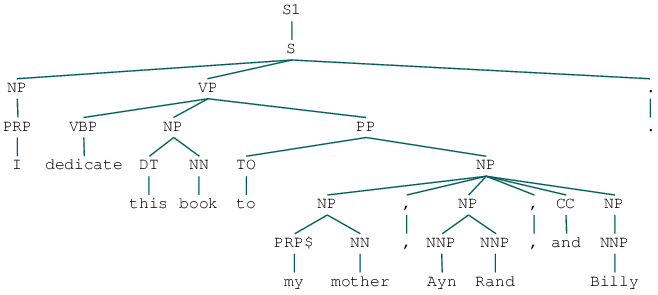

In [3]:
rrp.parse("I dedicate this book to my mother, Ayn Rand, and Billy.").fuse().as_nltk_tree()

### Incorrect

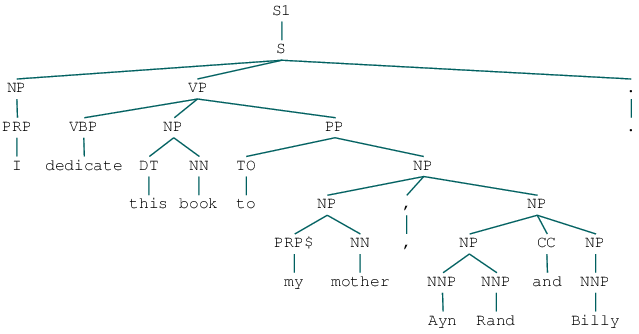

In [4]:
rrp.parse("I dedicate this book to my mother, Ayn Rand and Billy.").fuse().as_nltk_tree()

### Correct

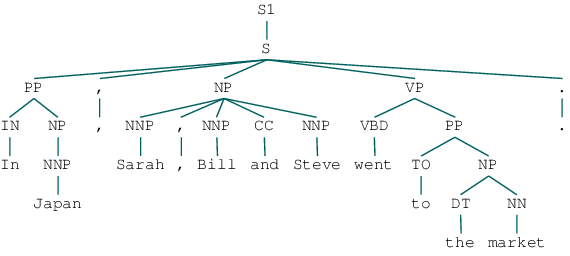

In [5]:
rrp.parse("In Japan, Sarah, Bill and Steve went to the market.").fuse().as_nltk_tree()

### A valid reading

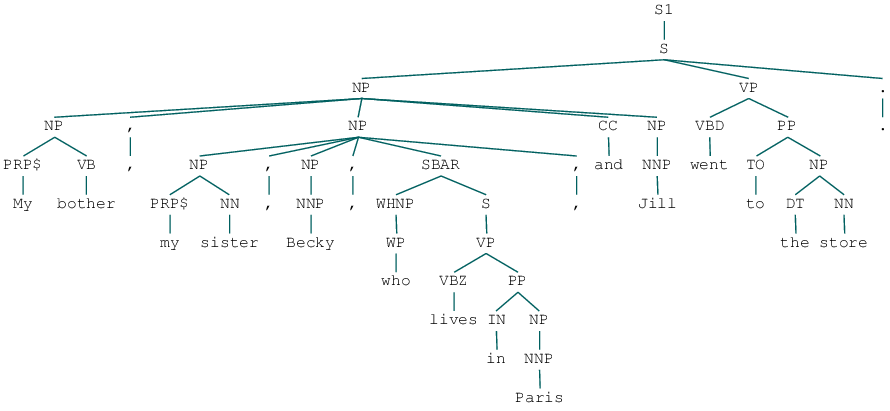

In [8]:
rrp.parse("My bother, my sister, Becky, who lives in Paris, and Jill went to the store.").fuse().as_nltk_tree()


### Incorrect

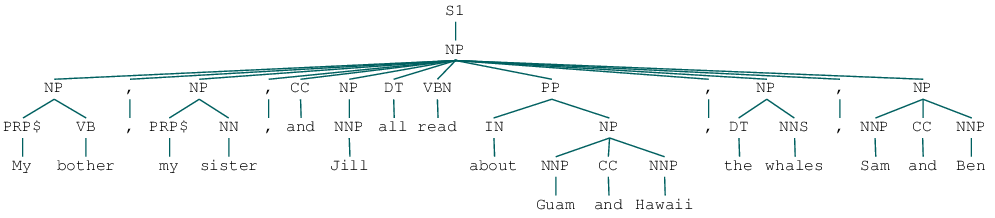

In [7]:
(rrp
 .parse("My bother, my sister, and Jill all read about Guam and Hawaii, the whales, Sam and Ben")
 .fuse()
 .as_nltk_tree())

In [9]:
def get_coordinated_nps(tree):
    if isinstance(tree, Tree):
        if tree.label() == 'NP':
            for coordinates in get_coordinates(tree):
                yield coordinates
        for subtree in tree:
            for coordinates in get_coordinated_nps(subtree):
                yield coordinates
                
def get_coordinated_with_coordinators_nps(tree):
    if isinstance(tree, Tree):
        if tree.label() == 'NP':
            for coordinates in get_coordinates(tree):
                yield coordinates
        for subtree in tree:
            for coordinates in get_coordinated_nps(subtree):
                yield coordinates
                
def adjust_for_sticky_final_nps(coordinates):
    if len(coordinates) > 1:
        if coordinates[-1].label() == 'NP' and len(coordinates[-1]) > 2:
            # match for NP|NN* (,) CC NP|NN*
            if (coordinates[-1][0].label()[:2] in ['NP', 'NN']
                and coordinates[-1][-1].label()[:2] in ['NP', 'NN']
                and coordinates[-1][-2].label()[:2] == 'CC' 
                and (len(coordinates[-1]) == 3
                     or (len(coordinates[-1]) == 4 and coordinates[-1][1].label()[:2] == ','))):
                coordinates = coordinates[:-1] + [coordinates[-1][0], coordinates[-1][-1]]
    return coordinates

def get_coordinates(tree):
    coordinates = []
    last_constituent_conjunct = True
    for subtree in tree:
        if last_constituent_conjunct and subtree.label()[:2] in ('NP', 'NN'):
            coordinates.append(subtree)
            last_constituent_conjunct = False
        elif subtree.label()[:2] in ('CC', ','):
            last_constituent_conjunct = True
        else:
            break
    # Common errors: ((John), (Bill and Scott)) or (John, (Bill, and Scott))
    # should be ((John), (Bill) and (Scott))
    coordinates = adjust_for_sticky_final_nps(coordinates)
    if len(coordinates) > 2:
        yield coordinates
        
def get_number_from_np(tree):
    pos_list = [pos for orth, pos in tree.pos()]
    if pos_list[-1][-1] == 'S' or 'CC' in pos_list:
        return 'P'
    return 'S'

def get_number_from_np(tree):
    pos_list = [pos for orth, pos in tree.pos()]
    if type(tree[0]) == str:
        if tree.label() in ('NNS', 'NNPS'):
            return 'P'
        else:
            return 'S'
    if 'CC' in pos_list:
        return 'P'
    for subsubtree in reversed(tree):
        if subsubtree.label() == 'NP':
            return get_number_from_np(subsubtree)
        else:
            if subsubtree.label() in ('NNS', 'NNPS'):
                return 'P'
            if subsubtree.label() in ('NN', 'NNP'):
                return 'S'
    return 'S'

def which_is_more_ambiguous(numbers):
    if numbers[-3:] == ['S', 'S', 'S']: return 'Oxford' # my mother, Jill, and Sam
    if numbers[-3:] == ['S', 'S', 'P']: return 'Oxford' # my mother, Jill, and the Smiths
    if numbers[-3:] == ['S', 'P', 'S']: return 'Neither' # my mother, the Smiths, and Sam
    if numbers[-3:] == ['S', 'P', 'P']: return 'Neither' # my mother, the Smiths, and the Joneses
    if numbers[-3:] == ['P', 'S', 'S']: return 'Lack of Oxford' # my parents, Jill and Sam
    if numbers[-3:] == ['P', 'P', 'S']: return 'Lack of Oxford' # my family, the Smiths and Sam
    if numbers[-3:] == ['P', 'S', 'P']: return 'Lack of Oxford' # my family, Sam and the Smiths
    if numbers[-3:] == ['P', 'P', 'P']: return 'Neither' # my family, the Smiths and the Joneses

In [10]:
tree = rrp.parse("I dedicate this book to my mother, Ayn Rand, and Billy.").fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert len(coords) == 1
assert [' '.join(np.leaves()) for np in coords[0]] == ['my mother', 'Ayn Rand', 'Billy']

In [11]:
tree = rrp.parse("I dedicate this book to my mother, Ayn Rand and Billy.").fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert len(coords) == 1
assert [' '.join(np.leaves()) for np in coords[0]] == ['my mother', 'Ayn Rand', 'Billy']

In [12]:
tree = rrp.parse("John, Bill, and Sarah dedicate this book to my mother, Ayn Rand and Billy.").fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
        == [['John', 'Bill', 'Sarah'], 
            ['my mother', 'Ayn Rand', 'Billy']])

In [13]:
tree = rrp.parse("I dedicate this book to my parents, Ayn Rand and Alan Greenspan, and Billy.").fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert len(coords) == 1
assert [' '.join(np.leaves()) for np in coords[0]] == ['my parents', 'Ayn Rand and Alan Greenspan', 'Billy']
assert [get_number_from_np(np) for np in coords[0]] == ['P', 'P', 'S']

In [14]:
# http://mentalfloss.com/article/33637/best-shots-fired-oxford-comma-wars
tree = (rrp.parse(
    "Those at the ceremony were the commodore, the fleet captain, the donor of the cup, Mr. Smith, and Mr. Jones."
).fuse().as_nltk_tree())
coords = list(get_coordinated_nps(tree))
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
 == [['the commodore', 'the fleet captain', 'the donor of the cup', 'Mr. Smith', 'Mr. Jones']])
assert ([[get_number_from_np(np) for np in coord] for coord in coords] == [['S', 'S', 'S', 'S', 'S']])
assert ([which_is_more_ambiguous([get_number_from_np(np) for np in coord]) for coord in coords] == ['Oxford'])

In [15]:
# http://mentalfloss.com/article/33637/best-shots-fired-oxford-comma-wars
# original "She took a photograph of her parents, the president, and the vice president."
# Parsed as: She took ((a photograph of her parents), (the president), and (the vice president)).
# Most probably: parsed as: She took a photograph of ((her parents), (the president), and (the vice president)).
tree = (rrp.parse(
    "She saw her parents, the president, and the vice president."
).fuse().as_nltk_tree())
coords = list(get_coordinated_nps(tree))
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
 == [['her parents','the president','the vice president']])
assert ([[get_number_from_np(np) for np in coord] for coord in coords] == [['P', 'S', 'S']])
assert ([which_is_more_ambiguous([get_number_from_np(np) for np in coord]) for coord in coords] == ['Lack of Oxford'])

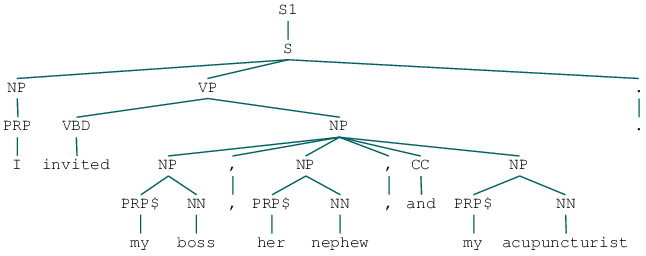

In [16]:
# https://www.newyorker.com/culture/culture-desk/in-defense-of-nutty-commas
tree = (rrp.parse(
   "I invited my boss, her nephew, and my acupuncturist."
).fuse().as_nltk_tree())
'''
coords = list(get_coordinated_nps(tree))
print(coords)
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
 == [['train','plane','sedan chair']])
assert ([[get_number_from_np(np) for np in coord] for coord in coords] == [['S', 'S', 'S']])
assert ([which_is_more_ambiguous([get_number_from_np(np) for np in coord]) for coord in coords] == ['Oxford'])
'''
tree

In [17]:
# http://mentalfloss.com/article/33637/best-shots-fired-oxford-comma-wars
tree = (rrp.parse(
   "This book is dedicated to my parents, Ayn Rand and God"
).fuse().as_nltk_tree())
coords = list(get_coordinated_nps(tree))
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
 == [['my parents', 'Ayn Rand', 'God']])
assert ([[get_number_from_np(np) for np in coord] for coord in coords] == [['P', 'S', 'S']])
assert ([which_is_more_ambiguous([get_number_from_np(np) for np in coord]) for coord in coords] == ['Lack of Oxford'])

In [18]:
tree = rrp.parse('Much more serious for Hong Kong is the disadvantage of action restraining trade," he said.').fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert coords == []

In [19]:
tree = rrp.parse(
    "He said Australia's concerns centred on coal and beef, Australia's two largest exports to Japan and also significant U.S. Exports to that country."
).fuse().as_nltk_tree()
coords = list(get_coordinated_nps(tree))
assert ([[' '.join(np.leaves()) for np in coord] for coord in coords] 
        == [['coal and beef',
             "Australia 's two largest exports to Japan",
             'also significant U.S. Exports to that country']])
assert ([[get_number_from_np(np) for np in coord] for coord in coords] == [['P', 'P', 'P']])
assert ([which_is_more_ambiguous([get_number_from_np(np) for np in coord]) for coord in coords] == ['Neither'])



In [33]:
def parse_sentence(raw: str):
    try:
        tree = rrp.parse(raw).fuse().as_nltk_tree()
    except:
        print('bad sentence')
        print(reformated_sentence)
        return []
    #print(reformated_sentence)
    data = []
    for coord in get_coordinated_nps(tree):
        nps = [' '.join(np.leaves()) for np in coord]
        try:
            numbers = [get_number_from_np(np) for np in coord]
        except:
            continue
        ambiguity = which_is_more_ambiguous(numbers)
        entry = {'fileid': fileid, 
                 #'tree': tree,
                 'sent': reformated_sentence,
                 'nps': nps,
                 'numbers': numbers,
                 'ambiguity': ambiguity}
        data.append(entry)
    return data


In [21]:
nlp = spacy.en.English()

In [22]:
nltk.download('gutenberg')
nltk.download('reuters')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/kesslej/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to /Users/kesslej/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [23]:

# patch to get the bllipparser to work with dask
'''
import dask.bag as db
import sys
sys.modules['JohnsonReranker'] = bllipparser.JohnsonReranker
'''
import time
o = open('guetenberg.json.txt', 'w')
data = []
for fid, fileid in enumerate(gutenberg.fileids()):
    print(fileid, fid, len(gutenberg.fileids()))
    raw = gutenberg.raw(fileid)
    #print(raw_documents_less_headline)
    parsed_doc = nlp(raw)
    num_sents = len(list(parsed_doc.sents))
    t0 = time.time()
    for senti, sent in enumerate(parsed_doc.sents):
        if senti % 10: print(senti/num_sents, num_sents, (num_sents - sent_i) * (time.time() - t0)/(senti + 1))
        reformated_sentence = html.unescape(' '.join(str(sent).split()))
        data += parse_sentence(reformated_sentence)
geutenberg_df = pd.DataFrame(data)

austen-emma.txt 0 18


NameError: name 'sent_i' is not defined

In [ ]:
geutenberg_df.dropna().to_csv('geutenberg_ambiguity.csv', index=False)

In [152]:

# patch to get the bllipparser to work with dask
'''
import dask.bag as db
import sys
sys.modules['JohnsonReranker'] = bllipparser.JohnsonReranker
'''
data = []
for fileid in reuters.fileids()[14:]:
    print(fileid)
    raw_documents_less_headline = '\n'.join(reuters.raw(fileid).split('\n')[1:])
    #print(raw_documents_less_headline)
    parsed_doc = nlp(raw_documents_less_headline)
    for sent in parsed_doc.sents:
        #print(sent)
        reformated_sentence = html.unescape(' '.join(str(sent).split()))
        data.append({'fileid': fileid, 'sent':reformated_sentence})
        try:
            tree = rrp.parse(reformated_sentence).fuse().as_nltk_tree()
        except:
            print('bad sentence')
            print(reformated_sentence)
            continue
        #print(reformated_sentence)
        for coord in get_coordinated_nps(tree):
            nps = '~~~'.join([' '.join(np.leaves()) for np in coord])
            try:
                numbers = [get_number_from_np(np) for np in coord]
            except:
                import pdb; pdb.set_trace()
                continue
            ambiguity = which_is_more_ambiguous(numbers)
            entry = {'fileid': fileid, 
                     #'tree': tree,
                     'sent': reformated_sentence,
                     'nps': nps,
                     'numbers': numbers,
                     'ambiguity': ambiguity}
            print(entry)
            data.append(entry)


test/14858
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'test/14858', 'nps': 'fruit juices~~~purees~~~pulp', 'sent': 'The U.S. Has also asked the General Agreement on Tariffs and Trade to investigate the legality of Japanese import controls on 12 other farm products, including fruit juices, purees and pulp, tomato juice, ketchup and sauce, peanuts, prepared beef products and miscellaneous beans.'}
test/14859
test/14860
test/14861
test/14862
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'test/14862', 'nps': 'eight pct GNP growth~~~five billion dlrs of -LRB- current account -RRB- surplus~~~12 pct growth in exports', 'sent': '"Our government projections of eight pct GNP growth, five billion dlrs of (current account) surplus and 12 pct growth in exports all seemed to be reasonable early this year.'}
test/14863
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/14863', 'nps': 'Neste Oy~~~Celanese Canada Inc~~~Hoechst Celanese C

test/15033
test/15037
test/15038
test/15043
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/15043', 'nps': 'sunflower~~~maize~~~sorghum', 'sent': 'They said sunflower, maize and sorghum production estimates had been reduced despite some later warm, dry weather, which has allowed a return to harvesting in some areas.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P', 'S', 'S', 'S'], 'fileid': 'test/15043', 'nps': '83 mm in Cordoba~~~41 in Santa Fe~~~50 in Entre Rios and Misiones~~~95 in Corrientes~~~eight in Chaco~~~35 in Formosa', 'sent': 'Rains in the middle of last week reached an average of 27 millimetres in parts of Buenos Aires province, 83 mm in Cordoba, 41 in Santa Fe, 50 in Entre Rios and Misiones, 95 in Corrientes, eight in Chaco and 35 in Formosa.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/15043', 'nps': 'Cordoba~~~La Pampa~~~Buenos Aires', 'sent': 'Deterioration of the sunflower crop evident in harvested material in Cordoba, L

test/15149
test/15152
test/15153
test/15154
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/15154', 'nps': 'the Deputy U.S. Trade Representative~~~Michael Smith~~~the Under Secretary of Commerce , Bruce Smart', 'sent': "Makoto Kuroda, vice minister of Japan's Ministry of International Trade and Industry (MITI), is to hold two days of meetings with the Deputy U.S. Trade Representative, Michael Smith, and the Under Secretary of Commerce, Bruce Smart."}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'test/15154', 'nps': 'television~~~audio equipment~~~computers', 'sent': 'They are to be imposed on goods which use semiconductors, including television and audio equipment and computers.'}
test/15156
test/15157
test/15161
test/15162
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/15162', 'nps': 'its primary markets~~~flat revenues~~~increased costs', 'sent': 'The trucking company attributed the loss to the continued rate of discounted in

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'test/15308', 'nps': "Gilbey 's gin and vodka~~~DeKuyper Liqueurs~~~Windsor Supreme Canadian Whisky", 'sent': "National's spirits brands include Gilbey's gin and vodka, DeKuyper Liqueurs and Windsor Supreme Canadian Whisky."}
test/15309
test/15310
test/15311
test/15312
test/15313
test/15314
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'P'], 'fileid': 'test/15314', 'nps': 'Rolls Royce PLC~~~<Japanese Aero Engines Corp>~~~Fiat SPA~~~<MTU> of West Germany', 'sent': "IAE's other owners are Rolls Royce PLC, <Japanese Aero Engines Corp>, Fiat SPA and <MTU> of West Germany."}
test/15315
test/15321
test/15322
test/15324
test/15325
test/15326
test/15327
test/15329
test/15335
test/15336
test/15337
test/15339
test/15341
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/15341', 'nps': 'about 55,000 tonnes of vegetable oil~~~55,000 tonnes of corn~~~126,000 tonnes of wheat', 'sent': 'The official noted the

test/15441
test/15442
test/15444
test/15446
test/15447
test/15448
test/15449
test/15450
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'P'], 'fileid': 'test/15450', 'nps': 'the United States~~~Japan~~~West Germany~~~France , Britain , Italy and Canada', 'sent': 'The meeting of the so-called Group of Seven brought together ministers and central bank governors of the seven major industrial democracies, the United States, Japan, West Germany, France, Britain, Italy and Canada.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/15450', 'nps': 'France~~~Britain~~~Italy~~~Canada', 'sent': 'The meeting of the so-called Group of Seven brought together ministers and central bank governors of the seven major industrial democracies, the United States, Japan, West Germany, France, Britain, Italy and Canada.'}
test/15451
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'test/15451', 'nps': 'the lower dollar rate~~~high initial costs for new products~~~the c

test/15605
test/15607
test/15610
test/15613
test/15615
test/15616
test/15617
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'test/15617', 'nps': 'the United States~~~Japan~~~West Germany', 'sent': 'Lawson said he was still worried about the risk of a simultaneous recession in the United States, Japan and West Germany, though less so than when he gave his March 17 budget speech to the British Parliament. "If anything I\'m a little bit less concerned, but there is still a risk," he said.'}
test/15618
test/15620
test/15621
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S'], 'fileid': 'test/15621', 'nps': 'the United States~~~Canada , Britain , Japan , Italy~~~West Germany~~~France', 'sent': 'The G-10 includes the group of seven - the United States, Canada, Britain, Japan, Italy, West Germany and France - plus Belgium, the Netherlands, Sweden and also Switzerland.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/15621', 'nps': 'Canada~~

test/15854
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/15854', 'nps': '122,900,000 boxes~~~vs 124,000,000 last month~~~119,000,000 boxes in 1985/86', 'sent': 'Florida oranges (excluding Temples) -- 122,900,000 boxes, vs 124,000,000 last month and 119,000,000 boxes in 1985/86.'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/15854', 'nps': '3,400,000 boxes~~~vs 3,400,000 last month~~~2,950,000 boxes in 1985/86', 'sent': 'Florida Temples -- 3,400,000 boxes, vs 3,400,000 last month and 2,950,000 boxes in 1985/86.'}
test/15855
test/15856
test/15858
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/15858', 'nps': '79,100 acres~~~vs 76,700 acres estimated last month~~~75,900 acres harvested last year', 'sent': 'The department estimated spring potato area for harvest at 79,100 acres, vs 76,700 acres estimated last month and 75,900 acres harvested last year.'}
test/15859
test/15860
{'ambiguity': 'Lack of Oxford', '

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/15911', 'nps': 'June 1~~~corn September 1~~~soybean meal', 'sent': 'The marketing year for wheat begins June 1, corn September 1, and soybean meal October 1.'}
test/15912
test/15913
test/15914
bad sentence
Production 27.62 27.62 24.95 24.95 Imports 0.30 0.30 0.31 0.31 Dom Use 19.80 19.80 18.99 18.96 Exports 7.41 7.21 4.74 4.72 End Stocks 6.90 7.10 6.19 6.19 THAILAND COARSE GRAINS, in mln tonnes -- 1986/87 1985/86 04/09/87 03/09/87 04/09/87 03/09/87 Start Stcks 0.49 0.38 0.16 0.16 Production 4.40 4.40 5.67 5.47 Imports NIL NIL NIL
test/15916
test/15917
test/15918
test/15920
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/15920', 'nps': 'Shasta Beverages~~~Spree All Natural Beverages~~~private label brands', 'sent': 'National Beverage, which is also privately held, owns and bottles Shasta Beverages, Spree All Natural Beverages and private label brands in its 11 bottling facilities in the United State

test/15996
test/15997
test/15999
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/15999', 'nps': '152,600 tonnes of wheat~~~6,808,100 tonnes of corn~~~1,518,700 tonnes of soybeans', 'sent': 'Total shipments in the third year of the U.S.-USSR grains agreement, which ended September 30, amounted to 152,600 tonnes of wheat, 6,808,100 tonnes of corn and 1,518,700 tonnes of soybeans.'}
test/16002
test/16003
test/16004
test/16005
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'test/16005', 'nps': '18.55 dlrs~~~a decline of 68 cts a barrel~~~3.5 pct from the previous week', 'sent': 'Attaka in Singapore is valued at 18.55 dlrs, a decline of 68 cts a barrel or 3.5 pct from the previous week.'}
test/16006
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/16006', 'nps': 'increased publicity for IMF appraisals developed in Article IV consultations~~~the use of follow-up reports on country actions to implement IMF recommendations~~~greate

test/16141
test/16142
test/16143
test/16144
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'test/16144', 'nps': 'China~~~Egypt~~~Iran~~~Iraq~~~the Soviet Union~~~Japan', 'sent': "Australia's leading wheat markets include China, Egypt, Iran, Iraq, the Soviet Union and Japan."}
test/16145
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S'], 'fileid': 'test/16145', 'nps': '233,448 Norcros ordinary shares~~~0.18 pct~~~180,240 preference shares~~~8.19 pct', 'sent': '<Williams Holdings Plc> said that it had received acceptances for its offer for Norcros Plc <NCRO.L> from the holders of 233,448 Norcros ordinary shares, or 0.18 pct, and 180,240 preference shares, or 8.19 pct.'}
test/16146
test/16147
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'P'], 'fileid': 'test/16147', 'nps': 'corn~~~rice~~~cottonseed~~~shelled peanuts', 'sent': 'China has raised the state purchase prices of corn, rice, cottonseed and shelled peanuts from April 1 to encourage farmer

test/16265
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/16265', 'nps': 'grains~~~oilseeds~~~derivatives', 'sent': 'Graan Elevator Mij, GEM, said its balance in port of grains, oilseeds and derivatives rose to 146,000 tonnes on April 11 from 111,000 a week earlier after arrivals of 404,000 tonnes and discharges of 369,000 tonnes last week.'}
test/16266
test/16268
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/16268', 'nps': 'Kiel~~~Hamburg~~~Essen', 'sent': 'The five institutes issued a joint spring report, in which three -- Kiel, Hamburg and Essen -- forecast a two pct rise in GNP in 1987, while West Berlin and Munich predicted one pct.'}
test/16269
test/16270
test/16271
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/16271', 'nps': 'Chicago~~~Denver~~~Toledo', 'sent': 'The officials said hard red spring wheat prices at Chicago, Denver and Toledo were adjusted by about the same amount as at Pacific Northwest, Duluth and M

test/16380
test/16383
test/16385
test/16386
test/16388
test/16390
test/16392
test/16393
test/16394
test/16395
test/16396
test/16398
test/16399
test/16400
test/16401
test/16402
test/16403
test/16404
test/16405
test/16406
test/16407
test/16409
test/16410
test/16415
test/16417
test/16418
test/16419
test/16420
test/16421
test/16422
test/16424
test/16426
test/16427
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/16427', 'nps': "VBI Corp , a Turks and Caicos Islands investment firm ,~~~Ingemar Rydin Industritillbehor AB , a Swedish investment firm ,~~~Erik Martin Vik , a Norwegian investor , and Vik 's son , Alexander", 'sent': "The group includes VBI Corp, a Turks and Caicos Islands investment firm, and Ingemar Rydin Industritillbehor AB, a Swedish investment firm, and Erik Martin Vik, a Norwegian investor, and Vik's son, Alexander."}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/16427', 'nps': "Erik Martin Vik~~~a Norwegian investor~~~Vik '

test/16650
test/16651
test/16652
test/16653
test/16654
test/16655
test/16656
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/16656', 'nps': 'pension funds~~~insurance companies~~~other institutional investors', 'sent': 'The investors involved with Merrill include pension funds, insurance companies and other institutional investors, sources said.'}
test/16658
test/16662
test/16663
test/16664
test/16665
test/16667
test/16668
test/16670
test/16672
test/16675
test/16676
test/16677
test/16678
test/16679
test/16680
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/16680', 'nps': 'Atlantic Richfield~~~British Petroleum~~~Conoco~~~Amoco', 'sent': 'Representatives of Atlantic Richfield, British Petroleum, Conoco and Amoco were not immediately available for comment.'}
test/16681
test/16684
test/16685
test/16687
test/16688
test/16695
test/16698
test/16700
test/16705
test/16706
test/16707
test/16708
test/16710
{'ambiguity': 'Oxford', 'numbers': ['S', 'S'

test/16872
test/16873
test/16874
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'test/16874', 'nps': 'The firms~~~Boston-based FMR Corp~~~Bermuda-based Fidelity International Ltd', 'sent': 'The firms, Boston-based FMR Corp and Bermuda-based Fidelity International Ltd, said they bought a combined 103,000 Orient Express common shares from March 12 to April 8 at prices ranging from 3.05 to 3.55 dlrs each.'}
test/16875
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/16875', 'nps': 'Charles R. Miller~~~Richard E. Ragsdale~~~Richard L. Scott', 'sent': 'Hospital Corp of America said its management believes the 47 dlr per share acquisition offer it received from Charles R. Miller, Richard E. Ragsdale and Richard L. Scott is not in the best interest of shareholders, and it does not plan to meet with the individuals.'}
test/16884
test/16885
test/16886
test/16888
test/16890
test/16893
test/16897
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 

test/17577
test/17579
test/17580
test/17584
test/17585
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'test/17585', 'nps': 'Steero Bouillon of Jersey City~~~N.J.~~~Blue Channel Inc~~~a Beaufort~~~S.C.~~~producer of canned crabmeat~~~the canned shrimp products line of DeJean Packing Inc of Biloxi~~~Miss. Borden', 'sent': 'Borden said the other three companies being acquired are Steero Bouillon of Jersey City, N.J., Blue Channel Inc, a Beaufort, S.C., producer of canned crabmeat, and the canned shrimp products line of DeJean Packing Inc of Biloxi, Miss. Borden also said the divestment of three operations with about 50 mln dlrs a year in sales is expected to produce nearly 45 mln dlrs in cash for use toward the purchase of new businesses.'}
test/17589
test/17593
test/17595
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/17595', 'nps': 'the sale~~~a previously-announced agreement for Coca-Cola to buy 1,600,000 Coke Consolidated co

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/17766', 'nps': '<American Seaways Foods Inc>~~~<Rini Holding Co>~~~<Rego Companies>', 'sent': '5300 is a Delaware corporation formed by <American Seaways Foods Inc>, <Rini Holding Co> and <Rego Companies> which owns 1.5 mln shares of Fisher, or about 44 pct of its outstanding common stock.'}
test/17767
test/17769
test/17770
test/17771
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'test/17771', 'nps': 'Atlantic Richfield Corp <ARC>~~~Shell Oil Co~~~a subsidiary of the Royal Dutch/Shell Group <RD> and Texaco Inc <TX>', 'sent': '" The Basin Pipeline is jointly owned by Atlantic Richfield Corp <ARC>, Shell Oil Co, a subsidiary of the Royal Dutch/Shell Group <RD> and Texaco Inc <TX>, which is the pipeline\'s operator.'}
test/17773
test/17775
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/17775', 'nps': 'new management~~~lower corporate overhead~~~a new location in Saddle Brook', 'sent': 

test/17881
test/17883
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'test/17883', 'nps': 'interest rate differentials~~~the fact that the dollar has fallen sharply in a very short period~~~an improvement in real trade balances', 'sent': 'The recent widening of interest rate differentials, the fact that the dollar has fallen sharply in a very short period and an improvement in real trade balances have all combined towards stabilizing the dollar, he said.'}
test/17886
test/17887
test/17888
test/17892
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/17892', 'nps': 'February~~~March~~~April', 'sent': 'Oman has granted term crude oil customers retroactive discounts from official prices of 30 to 38 cents per barrel on liftings made during February, March and April, the weekly newsletter Middle East Economic Survey (MEES) said.'}
test/17894
test/17896
test/17897
test/17899
test/17900
bad sentence
968.4 mln Profit from retail operations 133.3 mln stg 

test/18093
test/18095
test/18096
test/18099
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'test/18099', 'nps': 'Carol Tucker Foreman~~~President of Foreman and Heidepriem~~~a former assistant secretary of agriculture for food and consumer services', 'sent': 'Carol Tucker Foreman, President of Foreman and Heidepriem and a former assistant secretary of agriculture for food and consumer services, told a House Agriculture subcommittee, "every hour of every day, 22 Americans become victims of chicken contaminated with salmonella."'}
test/18101
test/18104
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/18104', 'nps': 'certain Japanese television sets~~~personal computers~~~hand-held power tools', 'sent': 'The sanctions were levied on certain Japanese television sets, personal computers and hand-held power tools.'}
test/18106
test/18108
test/18109
test/18111
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18111', 'nps': 'equipment~~~se

test/18276
test/18277
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18277', 'nps': 'Gress Foods~~~Inc -LRB- 5,000 tonnes -RRB-~~~Serva International Ltd -LRB- 5,000 tonnes -RRB-', 'sent': 'The bonuses were made to Gress Foods, Inc (5,000 tonnes), and Serva International Ltd (5,000 tonnes).'}
test/18280
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/18280', 'nps': "a Bingham , Utah , mine owned by Kennecott Corp~~~a unit of British Petroleum Co PLC 's <BP> Standard Oil Co~~~a mine in New Guinea~~~Phelps Dodge 's own expanded Morenci , Ariz. , mine", 'sent': "New production later this year from a Bingham, Utah, mine owned by Kennecott Corp, a unit of British Petroleum Co PLC's <BP> Standard Oil Co, a mine in New Guinea and Phelps Dodge's own expanded Morenci, Ariz., mine will be offset by production shortfalls in Mexico and Zambia, he said."}
test/18281
test/18283
test/18294
test/18296
test/18297
test/18300
test/18302
{'ambiguity': 'Oxford'

test/18521
test/18523
test/18524
test/18527
test/18530
test/18531
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18531', 'nps': 'the scheduled delivery payment of 14.10 dlrs~~~an additional sum of 2.35 dlrs~~~10 pct of the forecast price', 'sent': 'However, in addition to the scheduled delivery payment of 14.10 dlrs, an additional sum of 2.35 dlrs, or 10 pct of the forecast price, would be paid on December 15, on all cane harvested by November 30, he said.'}
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/18531', 'nps': 'harvesting gangs~~~cane growers~~~sugar industry trade unions', 'sent': 'He said he had directed the authorities to issue permits to harvesting gangs, cane growers and sugar industry trade unions to hold the necessary meetings in preparation for the commencement of harvest.'}
test/18533
test/18534
test/18536
test/18537
test/18538
test/18539
test/18540
test/18544
test/18549
test/18554
{'ambiguity': 'Oxford', 'numbers': ['S', 'S'

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18701', 'nps': '50 CTS A BBL~~~EFFECTIVE YESTERDAY~~~WTI', 'sent': 'DIAMOND SHAMROCK RAISES CRUDE OIL POSTED PRICES 50 CTS A BBL, EFFECTIVE YESTERDAY, WTI TO 19 DLRS.'}
test/18703
test/18704
test/18705
test/18706
test/18707
test/18708
test/18713
test/18718
test/18719
test/18721
test/18724
test/18728
test/18730
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'test/18730', 'nps': 'the previously reported acquisition of privately held Unimedia Inc~~~the owner of three French language daily newspapers~~~four printing plants in Ontario and Quebec', 'sent': 'Hollinger Inc said it completed the previously reported acquisition of privately held Unimedia Inc, the owner of three French language daily newspapers and four printing plants in Ontario and Quebec.'}
test/18732
test/18736
test/18738
test/18739
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18739', 'nps': 'Atlantic Richfield Co <ARC>~~

test/18910
test/18911
test/18917
test/18920
test/18921
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/18921', 'nps': "Citizens Banks ' name~~~management~~~board", 'sent': "CBC said the merger will not affect Citizens Banks' name, management, board of directors or employees."}
test/18922
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'test/18922', 'nps': 'its GTE Corp <GTE>~~~Bell Atlantic Corp <BEL>~~~NYNEX Corp <NYN>~~~US West Inc', 'sent': 'TIE/Communications Inc said it has renewed agreements to sell its GTE Corp <GTE>, Bell Atlantic Corp <BEL>, NYNEX Corp <NYN> and US West Inc <USW> for two years.'}
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/18922', 'nps': 'key systems~~~hybrids~~~DATA STAR PABX systems', 'sent': 'The company is providing small to mid-siezed key telephone systems to GTE and key systems, hybrids and DATA STAR PABX systems to the others.'}
test/18924
test/18930
test/18932
test/18938
{'ambiguity': 'Oxf

test/19062
test/19065
test/19069
test/19073
test/19075
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'test/19075', 'nps': "the higher gold price~~~a rise in the nation 's gold and foreign currency reserves~~~an improvement in the rand 's exchange rate to just under 50 U.S. Cents", 'sent': "The South African central bank said in its quarterly bulletin that confidence in the economy improved from January to May 31 because of the higher gold price, a rise in the nation's gold and foreign currency reserves and an improvement in the rand's exchange rate to just under 50 U.S. Cents."}
test/19077
test/19079
test/19081
test/19082
test/19083
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19083', 'nps': 'Nippon Oil~~~Idemitsu~~~Showa Shell', 'sent': "Japan's three biggest gasoline marketers, Nippon Oil, Idemitsu and Showa Shell, suffered supply shortages under the production quota guideline in fiscal 1986, ended last March."}
test/19087
test/19088
test/19092

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19318', 'nps': 'the Ivory Coast~~~El Salvador~~~Nicaragua', 'sent': 'Although full implications of the new formula have still to be worked out, initial estimates suggest countries such as Colombia, Kenya, Indonesia and Costa Rica would get slightly higher quotas, while others such as the Ivory Coast, El Salvador and Nicaragua would lose quota share, van Horick said.'}
test/19322
test/19325
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19325', 'nps': 'a possible sale , merger~~~corporate restructuring~~~leveraged buyout', 'sent': 'North American Communications Corp said it is considering several options to maximize shareholder value, including a possible sale, merger, corporate restructuring, or leveraged buyout.'}
test/19327
test/19329
test/19331
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19331', 'nps': 'Smith Barney~~~Harris Upham~~~Co Inc', 'sent': 'Primerica, wh ich cha

test/19451
test/19453
test/19458
test/19459
test/19461
test/19462
test/19463
test/19464
test/19466
test/19470
test/19471
test/19473
test/19474
test/19475
test/19477
test/19478
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'test/19478', 'nps': 'paper~~~chemicals~~~lumber', 'sent': 'He says the boost in production came from smaller industries like paper, chemicals, and lumber which have improved sales overseas due to the drop in the dollar.'}
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'test/19478', 'nps': 'a sharply lower dollar~~~higher oil and energy prices~~~rising prices for services', 'sent': 'The rise is coming from a sharply lower dollar, higher oil and energy prices and rising prices for services, he said.'}
test/19480
test/19482
test/19483
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19483', 'nps': 'Tuesday~~~Wednesday~~~Thursday', 'sent': 'In looking ahead to the U.S. Treasury mini-refunding auctions of 24.25 billion i

test/19737
test/19742
test/19744
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'test/19744', 'nps': 'IBM PCs~~~XTs~~~ATs~~~compatibles', 'sent': "The company said Storage Dimensions incorporates Maxtor's high-capacity 5-1/4-inch Winchester and optical disk drives into a family of data storage subsystems for IBM PCs, XTs, ATs and compatibles."}
test/19745
test/19748
test/19751
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/19751', 'nps': 'its two subsidiaries~~~Brookehill Equities Inc , a brokerage ,~~~Moore , Grossman and deRose Inc , an investment advisor', 'sent': 'The group, which currently holds 318,900 Cardis common shares, consists of New York-based Brookehill Partners and its two subsidiaries, Brookehill Equities Inc, a brokerage, and Moore, Grossman and deRose Inc, an investment advisor.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19751', 'nps': 'Moore~~~Grossman~~~deRose', 'sent': 'The group, w

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19844', 'nps': 'Venezuela~~~Nigeria~~~Kuwait', 'sent': '"We will be producing more than the quota to pay off the crude and products we have been lent by Venezuela, Nigeria and Kuwait and to compensate for the crude we have been unable to produce during the past few months," he said.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19844', 'nps': 'Venezuela~~~Nigeria~~~Kuwait', 'sent': 'While its production was down, Venezuela, Nigeria and Kuwait loaned Ecuador a total 12 mln barrels of crude and four mln barrels of products, Santos said.'}
test/19850
test/19854
test/19856
test/19860
test/19862
test/19864
test/19865
test/19866
test/19867
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/19867', 'nps': 'Britain~~~Denmark~~~the Netherlands', 'sent': 'Paris also supports a move for an oils and fats tax which West Germany is against, along with Britain, Denmark and the Netherlands.'}
t

test/20142
test/20145
test/20151
test/20153
test/20159
test/20161
test/20165
test/20166
test/20168
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/20168', 'nps': 'oilfied services~~~sale of small electronic business~~~unfavorable lease comitments', 'sent': '1986 3rd qtr and nine mths net includes a loss of 59 mln dlrs or 20 cts a share from continuing operations mainly for employee layoff costs in oilfied services, sale of small electronic business and unfavorable lease comitments.'}
test/20170
test/20174
bad sentence
Shr 31 cts vs 18 cts Net 90 mln vs 51 mln Sales 1.58 billion vs 1.42 billion Avg shrs 274 mln vs 269 mln Nine Mths Shr 79 cts vs 42 cts Net 233 mln vs 129 mln Sales 4.58 billion vs 4.22 billion Avg shrs 238 mln vs 267 mln NOTE: 1987 results include Caremark Inc from August 3.
test/20176
bad sentence
Oper shr profit 20 cts vs loss 22 cts Oper net profit 2,111,000 vs loss 1,605,000 Revs 89.6 mln vs 27.2 mln Nine mths Oper shr profit 47 cts vs los

test/20302
test/20304
test/20306
test/20308
test/20309
test/20310
test/20311
test/20314
test/20318
test/20319
test/20321
test/20324
bad sentence
Shr primary 1.79 dlrs vs 1.72 dlrs Shr diluted 1.39 dlrs vs 1.34 dlrs Net 12.1 mln vs 11.7 mln Nine mths Shr primary 5.56 dlrs vs 4.41 dlrs Shr diluted 4.30 dlrs vs 3.74 dlrs Net 37.3 mln vs 29.1 mln Assets 3.92 billion vs 3.83 billion Loans 3.05 billion vs 2.99 billion NOTE: 1987 qtr and nine mths includes gain 6,016,000 dlrs and 18.7 mln dlrs, respectively, from utilization of net operating loss carryforward.
test/20328
test/20332
bad sentence
Shr 4.77 dlrs vs 1.65 dlrs Net 61.3 mln vs 21.1 mln Revs 312.9 mln vs 291.5 mln Nine mths Shr 9.51 dlrs vs 4.98 dlrs Net 122.3 mln vs 63.9 mln Revs 950.4 mln vs 881.8 mln NOTE: 1987 net in both periods includes gains of 24.2 mln dlrs, or 1.88 dlrs a share, from sale of interest in Detroit Cellular telephone company and 6.1 mln dlrs, or 47 cts a share, from sale of interest in sportschannel Cable progra

test/20631
test/20632
test/20634
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S'], 'fileid': 'test/20634', 'nps': '1,374,000 dlrs~~~five cts per share~~~10.2 mln dlrs~~~41 cts per share', 'sent': 'Net profit 25.6 mln vs loss 26.8 mln Revs 73.4 mln vs 86.7 mln NOTE: 1987 qtr and nine mths includes gain 1,374,000 dlrs, or five cts per share, and 10.2 mln dlrs, or 41 cts per share, respectively, from net operating loss carryforward.'}
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S'], 'fileid': 'test/20634', 'nps': 'loss 4,850,000 dlrs~~~16 cts per share~~~loss 14.6 mln dlrs~~~58 cts per share', 'sent': '1987 qtr and nine mths includes loss 4,850,000 dlrs, or 16 cts per share, and loss 14.6 mln dlrs, or 58 cts per share, respectively, from payment of preferred dividends.'}
test/20637
test/20639
test/20640
test/20641
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'test/20641', 'nps': 'commercial ovens~~~conveyers~~~proofer systems', 'sent': 'Welbilt Corp said

test/20894
test/20896
test/20898
test/20900
bad sentence
Shr 38 cts vs 52 cts Net 3,980,000 vs 5,524,000 Revs 37.4 mln vs 44.8 mln Nine mths Shr 76 cts vs 99 cts Net 7,983,000 vs 10.5 mln Revs 100.4 mln vs 123.6 mln NOTE: 1987 qtr and nine mths includes loss 9,000 dlrs and 432,000 dlrs, or four cts per share, from repurchase and retirment of debt.
test/20901
test/20902
test/20904
test/20905
test/20907
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/20907', 'nps': 'Baker~~~Stoltenberg~~~Poehl', 'sent': 'Baker, Stoltenberg and Poehl had agreed to pursue the policies agreed under the Louvre pact with reference to currency stability and monetary policy.'}
test/20909
test/20910
test/20911
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'test/20911', 'nps': 'Malaysia~~~Indonesia~~~the Philippines', 'sent': 'The U.S. soybean industry believes labels indicating tropical oils are high in saturated fats would discourage consumption of the oils, imported primaril

bad sentence
Shr 87 cts vs 84 cts Net 418.6 mln vs 399.2 mln Revs 3.12 billion vs 2.89 billion Nine mths Shr 2.61 dlrs vs 2.62 dlrs Net 1.25 billion vs 1.23 billion Revs 9.10 billion vs 8.62 billion Avg shrs 481.4 mln vs 473.6 mln NOTE: Share adjusted for three-for-two stock split in February 1987.
test/21112
test/21113
test/21114
test/21117
test/21122
test/21123
test/21124
test/21128
test/21129
test/21130
test/21131
test/21132
test/21133
test/21134
test/21135
test/21136
test/21138
test/21140
test/21142
bad sentence
Oper shr 17 cts vs not available Oper net 1,619,000 vs 6,354,000 Nine Mths Oper shr 80 cts vs not available Oper net 7,675,000 vs 22,669,000 Assets 6.06 billion vs 5.74 billion Loans 3.11 billion vs 3.33 billion Deposits 4.57 billion vs 4.83 billion NOTE: 1987 operating net excludes tax credits of 3.9 mln dlrs or 40 cts a share in the quarter and 8.1 mln dlrs or 85 cts in the nine months period.
test/21143
test/21146
test/21148
test/21149
test/21151
test/21152
test/21157
te

test/21455
test/21459
test/21460
test/21462
test/21465
test/21466
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'test/21466', 'nps': 'Hong Kong Telephone~~~Cable~~~Wireless', 'sent': "Earlier today the company announced that Hong Kong Telephone and Cable and Wireless Hong Kong, in which the territory's government has a 20 pct stake, would become subsidiaries of a newly formed holding company, Hong Kong Telecommunications."}
test/21468
test/21469
test/21473
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'test/21473', 'nps': 'car manufacturers~~~electronic~~~electric firms', 'sent': 'More than 3,300 companies, including car manufacturers, electronic and electric firms, were hit by labour unrest between July and September.'}
test/21474
test/21475
test/21477
test/21478
test/21479
test/21480
bad sentence
Shr 18 cts vs 13 cts Net 5,436,000 vs 3,888,000 Sales 43.9 mln vs 31.5 mln Avg shrs 30,145,000 vs 28,976,000 Nine mths Shr 51 cts vs 38 cts Net 15,320

training/10073
training/10074
training/10075
training/10076
training/10078
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/10078', 'nps': 'its oil~~~natural gas liquids~~~natural gas reserves', 'sent': "The BP official said the 70 dlrs a share offer is 7.2 times Standard's 1986 cash flow and 56 pct above an independent evaluation of the company's assets, including the value of its oil, natural gas liquids and natural gas reserves."}
training/10079
training/1008
training/10080
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10080', 'nps': 'Prescott~~~Ball~~~Turben', 'sent': 'It\'s a 7.4 billion dlr price that (shows) OPEC has won the war and oil prices are not going to crack," said Prescott, Ball and Turben analyst Bruce Lazier. "Behind that is a huge implication for the rest of the energy issues out there in the stock market, particularly those that are acquisition targets," Lazier said.'}
training/10081
training/10083
training/10085
tra

training/10197
training/102
training/1020
training/10200
training/10201
training/10207
training/10208
training/10209
training/10211
training/10213
training/10214
training/10215
training/10216
training/10218
training/10219
training/1022
training/10222
training/10224
training/10225
training/10227
training/10228
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'training/10228', 'nps': 'one year~~~two years~~~three years', 'sent': 'The real question is how broad the valley is -- is it one year, two years or three years before we start to climb out?"'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/10228', 'nps': 'Farm-out agreements~~~cheap rig rates~~~less competition', 'sent': 'Farm-out agreements, cheap rig rates and less competition have held finding costs in those areas to five or six dlrs a barrel, Walter said.'}
training/1023
training/10230
training/10231
training/10233
training/10235
training/10237
training/10238
training/1024
{'ambigu

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/10311', 'nps': '<C Itoh and Co>. Merrill Lynch~~~Co Inc <MER>~~~Pacific Telesis International Inc <PAC>', 'sent': 'Cable and Wireless holds a 20 pct share in a second potential KDD rival, <International Digital Communications Planning Inc>, along with <C Itoh and Co>. Merrill Lynch and Co Inc <MER> and Pacific Telesis International Inc <PAC>, both of the U.S., Hold three and 10 pct shares respectively.'}
training/10313
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/10313', 'nps': "News Corp 's television assets~~~three newspapers~~~three radio stations", 'sent': "Of the placements, 56.9 mln shares will go to a number of investors and 72 mln to investment group <Westfield Capital Corp Ltd>, which arranged Northern Star's purchase of News Corp's television assets, three newspapers and three radio stations for 842 mln dlrs."}
training/10314
training/10315
training/10318
training/10319

training/10397
training/10398
training/10399
training/104
training/1040
training/10401
training/10402
training/10403
training/10404
training/10406
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'training/10406', 'nps': 'Wheat~~~tobacco~~~tea~~~coffee~~~jute~~~engineering', 'sent': 'Wheat, tobacco, tea, coffee, jute, engineering and electronic goods, as well as minerals including iron ore, are all on offer in return for crude oil, petroleum products, chemicals, steel and machinery, trade sources told Reuters.'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['S', 'P', 'P', 'S', 'S'], 'fileid': 'training/10406', 'nps': 'offer in return for crude oil~~~petroleum products~~~chemicals~~~steel~~~machinery', 'sent': 'Wheat, tobacco, tea, coffee, jute, engineering and electronic goods, as well as minerals including iron ore, are all on offer in return for crude oil, petroleum products, chemicals, steel and machinery, trade sources told Reuters.'}
training/10411
traini

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10519', 'nps': 'U.S. corn~~~wheat~~~rice', 'sent': 'Jamaica bought U.S. corn, wheat and rice at its tender earlier this week using PL-480 funds, a U.S. Department of Agriculture official said.'}
training/1052
training/10520
training/10521
training/10524
training/10527
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/10527', 'nps': 'approvals~~~waivers~~~forbearances', 'sent': 'The acquisition is subject to obtaining approvals, waivers and forbearances from the Federal Home Loan Bank Board and other government approvals.'}
training/10529
training/10530
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/10530', 'nps': 'personal computers~~~television receivers~~~laser-printers', 'sent': "The sources said the tariffs could be slapped on personal computers, television receivers and laser-printers, with the aim of penalizing Japan's major electronic firms, including NEC Corp

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10633', 'nps': 'experience among Arab banks~~~a paucity of financial instruments~~~a legal framework that often does not recognise the western banking concept of interest', 'sent': 'Nashashibi said lack of experience among Arab banks, a paucity of financial instruments and a legal framework that often does not recognise the western banking concept of interest have hampered the growth of Arab markets.'}
training/10634
training/10636
training/10638
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10638', 'nps': 'Ezzedine Saidane of Banque Internationale Arabe de Tunis~~~Mohammed Osman of Societe Bancaire du Liban~~~Walid Nasouli of Morgan Guaranty Trust Co of New York', 'sent': "The Inter-Arab Cambist Association (ICA) elected Abdullah al-Dakhil of Kuwait's Burgan Bank its new chairman, succeeding Hani Ramadan of Beirut Riyad Bank for a three-year term, ICA officials said The annual meeting ele

training/10766
training/10767
training/10768
training/10769
training/1077
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/1077', 'nps': 'machetes~~~knives~~~sticks', 'sent': 'The company said two groups of workers began attacking each other at about 1000 local time with machetes, knives and sticks at a hostel at the Zincor plant, some 40 kms east of Johannesburg.'}
training/10770
training/10771
training/10773
training/10774
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/10774', 'nps': 'consumer prices~~~exchange rates~~~economic and financial conditions', 'sent': 'Sumita said the central bank would continue to make a judgement on monetary policies while watching consumer prices, exchange rates and economic and financial conditions both in and outside Japan.'}
training/10779
training/1078
training/10780
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10780', 'nps': 'France~~~Britain~~~Canada', 'sent': 'The three 

training/10903
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/10903', 'nps': 'Britain~~~West Germany~~~the Netherlands~~~Denmark~~~Portugal', 'sent': 'He told a news conference held during a meeting here of EC agriculture ministers that Britain, West Germany, the Netherlands, Denmark, and Portugal were all against the tax.'}
training/10904
training/10905
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10905', 'nps': "its enormous worldwide trade surplus~~~the symbol of the U.S. trade crisis~~~the focus of its efforts to turn around America 's record trade deficit", 'sent': "The U.S. Congress is making Japan, with its enormous worldwide trade surplus, the symbol of the U.S. trade crisis and the focus of its efforts to turn around America's record trade deficit."}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/10905', 'nps': 'the challenge to our high technology industries~~~the threat of government nutur

training/11035
training/11036
training/11039
training/1104
training/11040
training/11041
training/11043
training/11046
bad sentence
Net profit 967,000 vs loss 1,219,000 Revs 10.1 mln vs 4.5 mln Year Shr profit three cts vs loss five cts Net profit 688,000 vs 982,000 Revs 24.6 mln vs 16.3 mln NOTE: 1986 includes results of Louisiana Energy and Development Corp acquired in November 1986.
training/11047
bad sentence
Shr 66 cts vs 33 cts Net 2,955,000 vs 1,563,000 Revs 26.1 mln vs 23.9 mln 12 mths Shr 74 cts vs 1.01 dlrs Net 3,321,000 vs 4,739,000 Revs 108.4 mln vs 104.9 mln NOTE: year 1987 includes charge of 818,000 dlrs, or 18 cts per share, for sale of Elisra Electronic Systems Ltd.
training/11048
training/11049
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S', 'S', 'P', 'S', 'P', 'S'], 'fileid': 'training/11049', 'nps': '2.4 mln dlrs~~~25 cts a share~~~three mln dlrs~~~32 cts a share~~~the prior third quarter~~~nine months net of 7.2 mln dlrs~~~76 cts a share~~~7.8 mln dlrs~~~82

training/11119
training/1112
training/11120
training/11121
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/11121', 'nps': 'carbon~~~HSLA~~~alloy', 'sent': 'Effective with shipments beginning June 28, the price on carbon, HSLA, and alloy plates will increase by 1-1/4 cts per pound.'}
training/11123
training/11124
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/11124', 'nps': 'plant expansion~~~infrastructure~~~the extension of hydroelectric facilities in the mineral-rich Guayana region , south of the Orinoco river', 'sent': 'The investments will go to plant expansion, infrastructure and the extension of hydroelectric facilities in the mineral-rich Guayana region, south of the Orinoco river.'}
training/11126
training/11127
training/11128
training/11132
training/11133
training/11134
training/11135
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/11135', 'nps': "protectionist moves by industrialised countries~~~

training/11243
training/11244
training/11249
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S'], 'fileid': 'training/11249', 'nps': 'terrorist attacks in Europe~~~the U.S. Bombing of the Libya~~~the Chernobyl disaster~~~a slump in the oil industry which affected Middle East traffic', 'sent': 'A decline in U.S. Transatlantic traffic following terrorist attacks in Europe, the U.S. Bombing of the Libya, the Chernobyl disaster and a slump in the oil industry which affected Middle East traffic were the main causes of the loss, Thomson said.'}
training/1125
training/11251
training/11252
training/11253
training/11254
training/11255
training/11256
training/11257
training/11259
training/11260
training/11261
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'training/11261', 'nps': 'consumer goods and materials~~~average work week~~~building permits', 'sent': "Besides stock prices, they were manufacturers' new orders for consumer goods and materials, average work week an

training/1138
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/1138', 'nps': 'BBDO~~~Doyle Dane Bernbach~~~Needham Harper Worldwide', 'sent': 'Shr profit 27 cts vs profit 51 cts Net profit 6,600,000 vs profit 12,231,000 Revs 211.7 mln vs 193.4 mln 12 mths Shr loss 17 cts vs profit 1.27 dlrs Net loss 4,077,000 vs profit 30,142,000 Revs 753.5 mln vs 673.4 mln NOTE: in qtr ended 1986 the company recognized expenses of 5,948,000 for restructing the combined operations of BBDO, Doyle Dane Bernbach and Needham Harper Worldwide in August 1986 before tax gains.'}
training/11380
training/11381
training/11384
training/11385
training/11386
training/11387
training/11388
training/11390
training/11392
training/11393
training/11394
training/11395
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/11395', 'nps': 'chairman~~~president~~~chief executive officer', 'sent': 'Hal Weiss, chairman, president and chief executive officer, of Rocky Mount Undergarment C

training/11523
training/11526
training/11527
training/11528
training/11529
training/1153
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/1153', 'nps': 'arrangement of financing~~~negotiation of a definitive agreement~~~various regulatory approvals', 'sent': 'Completion of the transaction is subject to arrangement of financing, negotiation of a definitive agreement, and various regulatory approvals, it said.'}
training/11536
training/11539
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/11539', 'nps': 'its Enro Shirt Co Inc~~~Enro-At-Ease Inc~~~Foxcroft Shirt Ltd subsidiaries', 'sent': 'Wilson Brothers said it completed the sale of most of the assets of its Enro Shirt Co Inc, Enro-At-Ease Inc and Foxcroft Shirt Ltd subsidiaries to Enro Acquisition Corp for about 24.2 mln dlrs, half in cash and half in subordinated promissory notes.'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/11539', 'nps': 'about 24.2 

training/11633
training/11634
training/11635
training/11636
training/11637
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/11637', 'nps': 'Pennsylvania~~~Delaware~~~Connecticut~~~Ohio', 'sent': 'He said, "the company currently has the sufficient momentum to achieve those earnings and the successful completion of licensing applications to operate in Pennsylvania, Delaware, Connecticut and Ohio should fuel our earnings."'}
training/11638
training/11639
training/1164
training/11640
training/11643
training/11644
training/11645
training/11649
training/11655
training/11657
training/11658
training/11660
training/11661
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/11661', 'nps': 'increasing exports~~~cheaper feedstock costs~~~the weakened U.S. dlr', 'sent': 'He predicted that the U.S. chemical industry, which reported a total of 13 billion dlrs in 1986 profits, would see a 20 pct gain in earnings this year because of increasing exp

training/11773
training/11774
training/11775
training/11776
training/11778
training/1178
bad sentence
Shr 42 cts vs 76 cts Net 2.3 mln vs 3.3 mln Revs 72.3 mln vs 59.8 mln Year Shr 1.48 dlrs vs 2.59 dlrs Net 7.6 mln vs 11.1 mln Revs 261.7 mln vs 224.7 mln NOTE: 1985 net includes extraordinary gain of 1.5 mln dlrs or 35 cts per share in 4th qtr and 5.1 mln or 1.19 dlrs for the year.
training/11783
training/11787
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/11787', 'nps': '4.80 billion~~~current 11.20 billion~~~sales 113 billion', 'sent': '10.85 billion vs 9.77 billion Operating 9.65 billion vs 9.54 billion Sales 103.53 billion vs 94.39 billion NOTE - Company forecast for current year is group shr 70.05 yen, net 4.80 billion, current 11.20 billion and sales 113 billion.'}
training/11789
training/11790
training/11791
training/11793
training/11794
training/11795
training/11798
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/11798', 'nps': 

training/11864
training/11866
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/11866', 'nps': 'International Coffee Organization~~~ICO~~~producers', 'sent': 'International Coffee Organization, ICO, producers will meet at 1500 GMT (0900 est) for a general discussion of the market situation, producer spokesman Lindenberg Sette said.'}
training/11867
training/11871
training/11872
training/11873
training/11876
training/11877
bad sentence
Shr loss nil vs profit nil Net loss 17,000 vs profit 31,000 Revs 5,429,000 up 27 pct Year Shr profit four cts vs profit five cts Net profit 523,000 vs profit 421,000 Revs 18.3 mln vs 11.6 mln Avg shrs 15.2 mln vs 8,941,000 NOTE: Year net includes tax credits of 131,000 dlrs vs 194,000 dlrs.
training/11878
training/11879
training/1188
training/11880
training/11882
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/11882', 'nps': "the country 's coffee exports~~~low oil prices~~~low inflation~~~rising 

training/11938
training/11939
training/11940
training/11941
training/11944
training/11945
training/11946
training/11947
training/11949
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/11949', 'nps': "the country 's coffee exports~~~low oil prices~~~low inflation~~~rising real incomes", 'sent': "This was owing to high prices for the country's coffee exports, low oil prices, low inflation and rising real incomes, he added."}
training/11953
training/11954
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/11954', 'nps': 'accessories~~~adhesives~~~tools', 'sent': 'Roberts makes and distributes accessories, adhesives and tools used in carpet installation.'}
training/11957
training/11958
training/11960
training/11961
training/11962
training/11964
training/11966
training/11967
training/11968
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/11968', 'nps': '140 mln dlrs of senior subordinated discount debentures~~

training/12119
training/1212
training/12121
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/12121', 'nps': 'government~~~unions~~~industry', 'sent': 'Lawson told the committee, which is a tripartite forum of government, unions and industry, that the pound would be kept near its present level by a mixture of interest rates and intervention in the foreign exchange markets.'}
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/12121', 'nps': 'government~~~unions~~~industry', 'sent': 'Lawson told the committee, which is a tripartite forum of government, unions and industry, that the pound would be kept near its present level by a mixture of interest rates and intervention in the foreign exchange markets.'}
training/12122
training/12125
training/12127
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/12127', 'nps': 'Orlando~~~Tampa~~~Jacksonville markets', 'sent': "The company said the restaurants in Orlando, Tampa and Jack

training/1226
training/12260
training/12261
training/12266
training/12267
training/12269
training/12270
training/12271
training/12274
training/12275
training/12276
training/12278
training/1228
training/12281
training/12283
training/12285
training/12286
training/12288
training/1229
training/12293
training/12294
training/12296
training/12298
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12298', 'nps': 'Stanley Tananbaum~~~chairman~~~chief executive officer', 'sent': 'Century Business Credit Corp said it received an offer from Stanley Tananbaum, chairman and chief executive officer, to take the company private in a transaction giveing shareholders 24.40 dlrs per share in cash.'}
training/123
training/12301
training/12302
training/12303
training/12304
training/12305
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/12305', 'nps': "Chemical Bank~~~Morgan Guaranty Trust Co of New York~~~Bankers Trust Co~~~Salomon Brothers Holding Co Inc , 

training/12398
training/12399
training/124
training/12400
training/12401
training/12403
training/12404
training/12406
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/12406', 'nps': 'sterling target rates~~~around 2.90 marks~~~1.60 dlrs', 'sent': "Dealers said the market was surprised by the Chancellor's disclosure of sterling target rates, around 2.90 marks and 1.60 dlrs, and nervous over the implications for domestic interest rates, further reducing the propects for a near term cut in U.K. Bank base rates."}
training/12407
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12407', 'nps': 'food~~~tobacco~~~alcohol', 'sent': 'Within this sector, the output of both basic products and of food, tobacco and alcohol fell 1-1/2 pct.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12407', 'nps': 'food~~~tobacco~~~alcohol', 'sent': 'Manufacturing industry output fell one pct, with output of basic products down three pct, ca

training/12464
training/12465
training/12466
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12466', 'nps': 'food~~~tobacco~~~alcohol', 'sent': 'Within this sector, the output of both basic products and of food, tobacco and alcohol fell 1-1/2 pct.'}
training/12468
training/12469
training/12470
training/12471
training/12472
training/12473
training/12480
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/12480', 'nps': 'its gold~~~foreign currency~~~other external assets', 'sent': 'The figures showed its gold, foreign currency and other external assets rose to 415.1 billion francs from 413 billion, mainly reflecting a rise to 116.7 billion from 114.7 billion in foreign exchange holdings.'}
training/12483
training/12484
training/12485
training/12487
training/12488
training/12489
training/12490
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12490', 'nps': 'the International Coffee Organization~~~ICO~~~executive board mee

training/12745
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/12745', 'nps': '546 mln stg~~~bills for repurchase by the market 76 mln~~~a rise in note circulation 310 mln~~~bankers balances', 'sent': 'Among the main factors, maturing assistance and take-up of treasury bills will drain 546 mln stg, bills for repurchase by the market 76 mln, a rise in note circulation 310 mln and bankers balances below target 105 mln.'}
training/12746
training/12748
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'training/12748', 'nps': 'six months~~~one year~~~two years', 'sent': 'The new CDs, with maturities of six months, one year and two years, carry interest rates ranging from 4.07 pct to 5.12 pct, he said.'}
training/12751
training/12752
training/12753
training/12754
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12754', 'nps': 'Britain~~~Pakistan~~~Egypt', 'sent': 'Kenya has for a long time relied on Britain, Pak

training/12842
training/12843
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P', 'P'], 'fileid': 'training/12843', 'nps': 'THE PAST 24 HOURS PARANA STATE UMUARAMA 10.6 MILLIMETRES~~~PARANAVAI 12.2 MM~~~LONDRINA 6.0 MM~~~MARINGA 8.0 MM', 'sent': 'THE FOLLOWING RAINFALL WAS RECORDDD IN THE AREAS OVER THE PAST 24 HOURS PARANA STATE UMUARAMA 10.6 MILLIMETRES, PARANAVAI 12.2 MM, LONDRINA 6.0 MM, MARINGA 8.0 MM.'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P', 'S', 'S'], 'fileid': 'training/12843', 'nps': 'PRESIDENZE PRUDENTE 1.0 MM~~~VOTUPORANGA 26.0 MM~~~FRANCA NIL~~~CATANDUVA 0.1 MM~~~SAO CARLOS NIL~~~SAO SIMAO NIL', 'sent': 'SAO PAULO STATE: PRESIDENZE PRUDENTE 1.0 MM, VOTUPORANGA 26.0 MM, FRANCA NIL, CATANDUVA 0.1 MM, SAO CARLOS NIL, SAO SIMAO NIL.'}
training/12846
training/12848
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'training/12848', 'nps': 'inflation~~~interest rate increases~~~trade confrontations', 'sent': 'Amid new concerns about inflation

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/12965', 'nps': 'L.F. Rothschild~~~Unterberg~~~Towbin Inc.', 'sent': "In a filing with the Securities and Exchange Commission, Warburg Pincus said one of its top executives, Rodman Moorhead, who is also a Symbion director, met April 1 with Symbion's financial advisor, L.F. Rothschild, Unterberg, Towbin Inc."}
training/12969
training/12971
training/12973
training/12974
training/12978
training/1298
training/12980
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'P'], 'fileid': 'training/12980', 'nps': 'The Chilean state copper corporation~~~Codelco~~~the privately-owned Chilean copper fabricator Madeco~~~Chinese interests', 'sent': "The Chilean state copper corporation, Codelco, the privately-owned Chilean copper fabricator Madeco and Chinese interests are to establish a copper tube plant in Peking, Codelco's U.K. Subsidiary Chile Copper Ltd said."}
training/12981
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'],

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'training/1316', 'nps': "3,650,000 dlrs~~~an increase in authorized common to 20 mln shares from 15 mln~~~the change of the company 's name to Royal Gold Inc. The company has agreed to sell its oil and gas properties to <Victoria Exploration N.L.> of Perth , Western Australia", 'sent': "Royal Resources Corp said its board set an April 21 a shareholders' meeting to vote on the sale of its oil and gas properties for 3,650,000 dlrs, an increase in authorized common to 20 mln shares from 15 mln and the change of the company's name to Royal Gold Inc. The company has agreed to sell its oil and gas properties to <Victoria Exploration N.L.> of Perth, Western Australia."}
training/13162
training/13163
training/13165
training/13168
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/13168', 'nps': 'two Alaskan electric utilities~~~the city and borough of Anchorage~~~the state of Alaska', 'sent': 'It

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/13210', 'nps': 'GenCorp~~~Wagner~~~Brown', 'sent': '"We wanted to remove our clients from the process unfolding between GenCorp and Wagner and Brown," he said.'}
training/13211
training/13212
training/13214
training/1322
training/13223
training/13224
training/13225
training/13230
training/13231
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/13231', 'nps': 'two weeks 2-1/4 pct~~~one month~~~two months 2-3/4 pct , three and six months 3-1/4 pct , nine months', 'sent': 'The deposit interest rates are now savings and 24 hours two pct, seven-day call, one week and two weeks 2-1/4 pct, one month and two months 2-3/4 pct, three and six months 3-1/4 pct, nine months 3-1/2 pct and 12 months four pct.'}
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'training/13231', 'nps': 'two months 2-3/4 pct~~~three and six months 3-1/4 pct~~~nine months', 'sent': 'The deposit interest rates are n

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/1350', 'nps': 'lemons~~~oranges~~~grapefruit~~~tangerines', 'sent': 'Arizona forecasts will be dropped for lemons, oranges, grapefruit and tangerines in November, December February, March, May and June, with forecasts retained in October, January, April and July, it said.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/1350', 'nps': 'October~~~January~~~April~~~July', 'sent': 'Arizona forecasts will be dropped for lemons, oranges, grapefruit and tangerines in November, December February, March, May and June, with forecasts retained in October, January, April and July, it said.'}
training/13507
training/1351
training/13512
training/13524
training/13530
training/13531
training/13532
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/13532', 'nps': 'its last reported full year~~~1985~~~6.0 mln', 'sent': 'It earned 11 mln U.S. Dlrs pre-tax in its last rep

training/13963
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S'], 'fileid': 'training/13963', 'nps': 'the United States~~~Soviet Union~~~Britain~~~China', 'sent': 'Kuwait has asked at least four countries, including the United States, Soviet Union, Britain and China, for temporary use of their flags or tankers to protect Kuwaiti oil shipments in the troubled Persian Gulf, Reagan Administration officials said.'}
training/13966
training/1398
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/1398', 'nps': 'Virgil Rosendale~~~a pork producer from Illinois~~~chairman of the National Pork Board', 'sent': 'Virgil Rosendale, a pork producer from Illinois and chairman of the National Pork Board, said over 2.2 mln dlrs was collected in January and refunds are running almost nine pct, considerably less than expected.'}
training/13988
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/13988', 'nps': 'the United States~~~Germany~~~Japan', 'se

training/1446
training/14469
training/14476
training/14483
training/14485
training/1449
training/14491
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/14491', 'nps': 'July 1-10 for 7,500-9,500 tonnes~~~August 1-10 for 8,000-10,000 tonnes~~~September 15-25 for 12,500-14,500 tonnes', 'sent': 'The agent said deliveries of northern spring/dns wheat will include laydays of July 1-10 for 7,500-9,500 tonnes, August 1-10 for 8,000-10,000 tonnes, and September 15-25 for 12,500-14,500 tonnes.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/14491', 'nps': 'June 20-30 for 5,000-7,000 tonnes~~~July 15-25 for 6,500-8,500 tonnes~~~September 15-25 for 7,000-9,000 tonnes', 'sent': 'Deliveries of hard red winter wheat will have laydays of June 20-30 for 5,000-7,000 tonnes, July 15-25 for 6,500-8,500 tonnes, and September 15-25 for 7,000-9,000 tonnes.'}
training/14499
training/145
training/14504
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 

training/1506
training/1508
training/151
training/1512
training/1514
training/1519
training/152
training/1520
training/1521
training/1524
training/1525
training/1526
training/1527
training/1528
training/1529
training/153
training/1532
training/1533
training/1535
training/1536
training/1537
training/1541
training/1543
training/1545
training/1546
training/1550
training/1553
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/1553', 'nps': 'interest rate swaps~~~forward foreign exchange contracts~~~similar financial instruments', 'sent': 'The proposal adopted today addresses only the credit risks associated with interest rate swaps, forward foreign exchange contracts and similar financial instruments.'}
training/1554
training/1555
training/1556
training/1557
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S'], 'fileid': 'training/1557', 'nps': 'cereals~~~beef~~~veal~~~wine', 'sent': 'The plan would initially apply to cereals, beef, veal and wine, they added.'}
tra

training/1665
training/1666
training/1667
training/167
training/1673
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/1673', 'nps': 'Richard A. Trydahl~~~Samuel Mineo~~~Charles E. Flink', 'sent': 'Nusource said shareholders elected a new board consisting of Richard A. Trydahl, Samuel Mineo and Charles E. Flink and voted to change the name of the company to ANW Inc.'}
training/1674
training/1675
training/1676
training/1677
training/1678
training/1679
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/1679', 'nps': 'cash~~~stock~~~notes.', 'sent': '<Asbestec Industries Inc> said it signed a letter of intent to buy asbestos abatement contractor <P.W. Stephens> for three mln dlrs in cash, stock and notes. The transaction is expected to be completed early in the third quarter of its fiscal year ending September 30, 1987.'}
training/168
training/1680
training/1681
training/1682
training/1684
training/1686
training/1688
training/1689
{'ambiguity': '

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/179', 'nps': 'low unemployment~~~financial stability~~~a large external payments surplus', 'sent': "Switzerland's economy, combining low unemployment, financial stability and a large external payments surplus, is in excellent condition and faces a satisfactory future, the Organisation for Economic Cooperation and Development, OECD, said."}
training/1790
training/1792
training/1794
training/1797
training/1798
training/1799
training/18
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/18', 'nps': 'Australia~~~Canada~~~Brazil~~~Japan.', 'sent': 'He said the company is a major shareholder of E.B.I. Foods Ltd, a United Kingdom blender, and has licensing arrangements in Australia, Canada, Brazil and Japan. "'}
training/180
training/1801
training/1803
bad sentence
Shr 17 cts vs 15 cts Net 229,000 vs 201,000 revs 10.5 mln vs 9.9 mln Year Shr 21 cts vs 55 cts Net 283,000 vs 766,000 Revs 40.4 mn vs

training/1949
training/1951
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'S', 'P', 'P'], 'fileid': 'training/1951', 'nps': 'computer microchips~~~supercomputers~~~Kansai airport~~~agricultural products~~~car telephones', 'sent': 'He named several areas of particular concern to Washington -- computer microchips, supercomputers, Kansai airport, agricultural products and car telephones.'}
training/1952
training/1959
training/196
training/1960
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'training/1960', 'nps': 'Oversea-Chinese Banking Corp Ltd~~~United Overseas Bank Ltd <UOBM.SI>~~~<Banque Paribas>~~~<Bangkok Bank Ltd~~~> <Citibank NA>~~~Standard Chartered Bank Ltd~~~Algemene Bank Nederland NV <ABNN.AS>~~~Banque Nationale De Paris <BNPP.PA>~~~<Chase Manhattan Bank', 'sent': 'The nine banks are Oversea-Chinese Banking Corp Ltd, United Overseas Bank Ltd <UOBM.SI>, <Banque Paribas>, <Bangkok Bank Ltd,> <Citibank NA>, Standard Chartered Bank Lt

{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/2108', 'nps': 'strong earnings momentum~~~its benefits from the lower dollar~~~anticipation of nice gains in margins', 'sent': '"We have been recommending the stock since it was in the 50s, but we reiterated today because of expectations of strong earnings momentum, its benefits from the lower dollar and anticipation of nice gains in margins," Merrill Lynch analyst Charles Ryan said.'}
training/2109
training/211
training/2110
training/2112
bad sentence
Oper shr 22 cts vs 20 cts Oper net 1,153,000 vs 1,068,000 Revs 15.7 mln vs 15.8 mln Six mths Oper shr 38 cts vs 38 cts Oper net 2,039,000 vs 2,051,000 Revs 31.4 mln vs 31.6 mln NOTE: exlcudes 145,000 discontinued operations for 1986 oper net for six mths for sale of electronics division.
training/2114
training/2115
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2115', 'nps': 'the Brazilian Coffee Institute~~~IBC~~~Jorio Dauster', 'sent': "Br

training/2213
training/2216
training/2217
training/2219
training/2220
training/2221
bad sentence
Shr Royal Dutch Petroleum Co <RD> 2.30 dlrs vs 2.90 dlrs Final Royal Dutch dividend of 8.30 guilders for total 12.80 guilders vs 12.80 guilders for 1985 Shr Shell Transport and Trading Co PLC <SC> 1.38 dlrs vs 1.65 dlrs Final Shell Transport dividend 118.0 pence for total of 172.0 pence vs 140.0 pence for 1985 Group Net 1.07 billion vs 1.24 billion Group Sales 20.42 billion vs 25.84 billion Year Shr Royal Dutch 8.65 dlrs vs 9.11 dlrs Net Shell Transport 4.78 dlrs vs 5.16 dlrs Group Net 3.71 billion vs 3.88 billion Group Sales 81.40 billion vs 94.57 billion NOTES: Group is 60 pct owned by Royal Dutch and 40 pct by Shell Transport Dollar amount of Royal Dutch dividend will depend on guilder/dollar exchange rate on May 14.
bad sentence
If LIFO accounting had been used, company said, Royal Dutch per share net would have been 1.78 dlrs vs 3.17 dlrs in quarter and 11.60 dlrs vs 9.53 dlrs in year,

training/2276
training/2278
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/2278', 'nps': 'Federal Reserve monetary policy~~~the Gramm-Rudman-Hollings legislation~~~the G-6 agreement~~~the Baker debt initiative for example', 'sent': 'Federal Reserve monetary policy, the Gramm-Rudman-Hollings legislation, the G-6 agreement, and the Baker debt initiative for example all have moved us in the right direction," he said.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/2278', 'nps': 'U.S.~~~Britain~~~France~~~Japan~~~West', 'sent': 'G-6 is comprised of U.S., Britain, France, Japan, West Germany and Canada.'}
training/2279
training/228
training/2281
training/2286
training/229
training/2290
training/2291
training/2297
training/2298
training/23
training/2301
training/2303
training/2304
training/2307
training/2308
training/2309
training/2310
training/2312
training/2316
training/232
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'],

training/2380
training/2382
training/2383
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/2383', 'nps': 'Qatar~~~Nigeria~~~Saudi Arabia~~~Iran', 'sent': 'Lukman said Qatar, Nigeria, Saudi Arabia and Iran had all produced in February below their Opec quotas.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2383', 'nps': 'its 1.238 mln bpd quota~~~Saudi Arabia 500,000 bpd less than its 4.133 mln allocation~~~Qatar 20 to 30 pct under its 285,000 bpd quota', 'sent': 'Lukman said that some industry reports "may be correct" that in February, Nigeria propuced 75-100,000 bpd below its 1.238 mln bpd quota, Saudi Arabia 500,000 bpd less than its 4.133 mln allocation and Qatar 20 to 30 pct under its 285,000 bpd quota.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2383', 'nps': 'Kuwait~~~Venezuela~~~Indonesia', 'sent': 'The Opec President said producers such as Kuwait, Venezuela and Indonesia were having less problem

training/2471
bad sentence
Oper shr profit 63 cts vs loss 1.15 dlrs Oper net profit 6,629,000 vs loss 12.4 mln Revs 23.6 mln vs 22.4 mln Year Oper shr profit 1.65 dlrs vs loss 1.28 dlrs Oper net profit 17.5 mln vs loss 13.8 mln Revs 93.1 mln vs 86.8 mln Note: Oper data does not include loss from discontinued operations of 7,932,000 dlrs, or 73 cts per shr in 4th qtr 1985, loss of 40.5 mln dlrs, or 3.83 dlrs per shr in the 1986 year or gain of 104.3 mln dlrs, or 9.68 dlrs per shr in 1985.
training/2474
training/2475
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2475', 'nps': 'Kidder~~~Peabody~~~Co.', 'sent': '"I think the merger is not going through," said Phil Pace, analyst at Kidder, Peabody and Co. He said the merger "lost a lot of its appeal" when the U.S. Department of Justice required that Baker sell off its Reed Tool Co operation.'}
training/2476
training/2478
training/2479
training/248
training/2480
training/2482
training/2483
bad sentence
Shr 36 cts vs

training/2572
training/2574
training/2576
training/2577
training/2578
training/2579
training/2580
training/2582
training/2583
training/2584
training/2585
training/2587
training/259
training/2590
training/2591
training/2593
training/2594
training/2595
training/2596
training/2599
training/260
training/2601
training/2602
training/2604
training/2606
training/2608
training/2609
training/2611
training/2613
training/2617
training/2618
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'P'], 'fileid': 'training/2618', 'nps': 'Consumer spending~~~capital spending~~~goverment spending~~~net exports', 'sent': '"Things just aren\'t adding up," said Steve Slifer of Lehman Goverment Securities Inc. "Consumer spending, capital spending, goverment spending, and net exports data show very weak first quarter GNP growth of one pct," he said.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2618', 'nps': 'Goldman~~~Sachs~~~Co', 'sent': 'Jason Benderly of Goldman, Sachs and Co note

training/2784
training/2785
training/2787
training/2789
bad sentence
Net profit 545,000 vs loss 13.1 mln Revs 75.3 mln vs 37.9 mln Avg shrs 14.8 mln vs 13.1 mln Year Shr profit 34 cts vs profit 34 cts Net profit 4,908,000 vs profit 4,487,000 Revs 216.8 mln vs 117.7 mln Avg shrs 14.6 mln vs 13.1 mln NOTE: 1985 net included gain on sale of foreign properties of 15.5 mln dlrs or 1.19 dlrs per share and a writedown of oil and gas properties of 12.5 mln dlrs or 96 cts per share.
training/279
training/2791
training/2792
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/2792', 'nps': 'so much complexity~~~so much inertia~~~so much bureacracy', 'sent': '"There\'s so much complexity, so much inertia, so much bureacracy, that stricly speaking about the mechanisms, it won\'t happen that fast," said analyst Victor Krueger of the Gartner Group.'}
training/2793
training/2794
training/2797
training/2798
training/2799
training/2800
training/2801
training/2802
{'ambiguity': 'Neith

training/2927
training/2928
training/2929
training/293
training/2930
training/2933
training/2936
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/2936', 'nps': 'uranium ore and oxide~~~iron and steel~~~coal~~~textiles', 'sent': "The South African sanctions law, enacted by the United States to protest the apartheid laws of racial segregation practiced by South Africa's white minority government, prohibited imports of uranium ore and oxide, iron and steel, coal and textiles at the end of 1986."}
training/2938
training/2939
training/2940
training/2942
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S', 'P'], 'fileid': 'training/2942', 'nps': 'uranium ore and oxide~~~iron and steel~~~coal~~~textiles', 'sent': "The South African sanctions law, enacted by the U.S. to protest the apartheid laws of racial segregation practiced by South Africa's white minority government, prohibited imports of uranium ore and oxide, iron and steel, coal and textiles at

training/3035
training/3036
training/3037
training/3038
training/3039
training/304
training/3040
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'P', 'P', 'S'], 'fileid': 'training/3040', 'nps': 'PRESIDENTE PRUDENTE O.6 MM~~~VOTUPORANGA 12.0 MM~~~FRANCA 28.0 MM~~~CATANDUVA 10.0 MM~~~SAO CARLOS NIL , SAO SIMAO NIL', 'sent': 'SAO PAULO STATE: PRESIDENTE PRUDENTE O.6 MM, VOTUPORANGA 12.0 MM, FRANCA 28.0 MM, CATANDUVA 10.0 MM, SAO CARLOS NIL, SAO SIMAO NIL.'}
training/3041
training/3042
training/3043
training/3044
training/3046
training/3047
training/3048
training/3049
training/3051
training/3053
training/3056
training/3057
training/3060
training/3061
training/3062
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/3062', 'nps': '<Oglethorpe Power Corp>~~~the Municipal Electric Authority of Georgia~~~the city of Dalton', 'sent': 'The nuclear power plant, located near Waynesboro, Ga., is co-owned by <Oglethorpe Power Corp>, the Municipal Electric Authority

training/3134
training/3135
training/3137
training/3138
training/3139
training/314
training/3142
training/3145
training/3146
training/3149
training/315
training/3152
training/3153
training/3154
training/3155
training/3157
training/3159
training/3161
training/3162
training/3163
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3163', 'nps': 'Special high grade~~~prime western~~~continuous galvanizing grade', 'sent': 'Special high grade, prime western and continuous galvanizing grade with controlled lead now costs 37-1/2 U.S. cents and 50 Canadian cents a pound.'}
training/3164
training/3166
training/3168
training/3169
training/317
training/3174
training/3176
training/3180
training/3181
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3181', 'nps': '1.5 cts a gallon~~~effective Saturday~~~March 7', 'sent': "Oil traders in the New York area said Exxon Corp's Exxon U.S.A. increased the price it charges contract barge customers for heating oil in

{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'P'], 'fileid': 'training/3287', 'nps': 'debenture holders~~~its landlord~~~a lessor of equipment to the marketing operation~~~holders of liabilities Pages is not assuming to arrange distribution of assets after the proposed sale , adding these assets will be significantly less than its liabilities', 'sent': 'Mathematical Applications said it is talking to debenture holders, its landlord, a lessor of equipment to the marketing operation and holders of liabilities Pages is not assuming to arrange distribution of assets after the proposed sale, adding these assets will be significantly less than its liabilities.'}
training/3290
training/3292
training/3295
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3295', 'nps': "700,000 dlrs cash~~~a secured promissory note for 1,506,000 dlrs~~~the forgiveness of a debt of 327,000 dlrs owed by Johnson Products to Debbie 's School", 'sent': "It said the sale price of 2,533,000

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P', 'S', 'P'], 'fileid': 'training/3390', 'nps': 'grains~~~livestock~~~metals~~~financials~~~foreign currencies', 'sent': 'The MidAm specializes in mini-contracts in grains, livestock, metals, financials and foreign currencies as well as some options contracts.'}
training/3394
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'P'], 'fileid': 'training/3394', 'nps': 'a tender offer~~~exchange offer~~~proxy contest~~~other ways', 'sent': 'In a previous SEC filing, the group has said it has decided to try to seek control of Prime Medical through a tender offer, exchange offer, proxy contest or other ways.'}
training/3395
training/3396
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'training/3396', 'nps': 'cash~~~notes~~~Chrysler shares', 'sent': "They said Chrysler's cost of acquisition was valued at 782 mln dlrs, paid in cash, notes and Chrysler shares."}
training/3399
training/3400
training/3401
training/3405
traini

training/3491
training/3492
training/3493
training/3497
training/3499
training/3504
training/3505
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/3505', 'nps': 'metals~~~oil~~~shipping', 'sent': "The Preussag statement said results fell in 1986 compared with 1985 because declines in earnings in metals, oil and shipping were not entirely compensated by positive trends in the group's other divisions."}
training/3507
training/3509
training/3511
training/3512
training/3514
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/3514', 'nps': 'banks on behalf of customers~~~payments for the federal railways loan stock~~~repayments of mark liabilities incurred by foreign central banks with the Bundesbank in the framework of the European Monetary System -LRB- EMS -RRB-', 'sent': 'A major tax payment period by banks on behalf of customers, payments for the federal railways loan stock and repayments of mark liabilities incurred by foreign central

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/3603', 'nps': 'six cts for April~~~four cts for May~~~five cts for June~~~seven cts for July~~~six cts', 'sent': 'PMI Fund Inc said its board declared monthly dividends of six cts for April, four cts for May, five cts for June, seven cts for July and six cts for August.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/3603', 'nps': 'March 23~~~April 17~~~May 15~~~June 12~~~July 17', 'sent': 'Dividends declared today are payable April Three, May Six, June Four, July Three and August Six to holders of record March 23, April 17, May 15, June 12 and July 17.'}
training/3604
training/3605
training/3607
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/3607', 'nps': "separate transactions~~~Kaiser Cement 's Northwest Terminals~~~Montana City plant", 'sent': "Hanson Industries, the U.S. arm of Hanson Trust PLC <HAN>, said it has proposed to sell, i

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3798', 'nps': 'the pay-back period of a property~~~its geographic location~~~the lifting cost of the crude oil', 'sent': 'Most buyers said the pay-back period of a property, its geographic location and the lifting cost of the crude oil are more important factors in evaluating potential acquisitions than relying on a simple price-per-barrel formula.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3798', 'nps': 'Texas~~~Oklahoma~~~Louisiana', 'sent': 'Rich Hodges, a Houston-based land manager representing International Oil and Gas Corp, a partnership of <Preussag Corp> and <C. Deilmann Inc> of West Germany, said the firm had earmarked at least 50 mln dlrs to spend on oil reserves in Texas, Oklahoma or Louisiana in the coming months.'}
training/38
training/3800
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/3800', 'nps': 'Vranitzky~~~Finance Minister Ferdinand La

{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P', 'P', 'P', 'P'], 'fileid': 'training/3981', 'nps': 'five to 50 mm in Corrientes~~~five to 31 mm in San Luis~~~five to 30 mm in Entre Rios~~~three to 20 mm in Misiones~~~11 to 17 mm in Formosa~~~one to eight mm in Chaco', 'sent': 'Rainfall totalled from five to 50 mm in Corrientes, five to 31 mm in San Luis, five to 30 mm in Entre Rios, three to 20 mm in Misiones, 11 to 17 mm in Formosa and one to eight mm in Chaco.'}
training/3982
training/3983
training/3984
training/3985
training/3989
training/399
training/3990
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3990', 'nps': 'Broad~~~Vogt~~~Conant', 'sent': 'The combined companies, to be called Broad, Vogt and Conant INc, will be the largest structural steel erection company in the U.S. Combined sales of the two operations were more than 40 mln dlrs in 1986.'}
training/3991
training/3993
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/3993'

training/407
training/4071
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'training/4071', 'nps': "Costa Rica~~~the Dominican Republic~~~Ecuador~~~Honduras~~~India~~~Papua New Guinea~~~Peru , which proposed a new quota system at last month 's failed International Coffee Organistion -LRB- ICO -RRB- talks in London", 'sent': "Indonesia was one of a group of eight producing countries, along with Costa Rica, the Dominican Republic, Ecuador, Honduras, India, Papua New Guinea and Peru, which proposed a new quota system at last month's failed International Coffee Organistion (ICO) talks in London."}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/4071', 'nps': 'the U.S.~~~Japan~~~the Netherlands~~~West Germany~~~Canada', 'sent': 'He said Indonesia was in contact with consumers such as the U.S., Japan, the Netherlands, West Germany and Canada ahead of an ICO executive board meeting scheduled for April 1.'}
{'ambiguity': 'Oxfo

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/4182', 'nps': 'Peter Valli~~~vice president of Borg-Warner Corp~~~president of its industrial products division', 'sent': 'Peter Valli, vice president of Borg-Warner Corp and president of its industrial products division, will become president and chief executive officer of the new company, according to Clayton.'}
training/4184
training/4185
training/4188
training/4189
training/4192
training/4193
training/4194
training/4199
training/42
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/42', 'nps': 'International Coffee Organization~~~ICO~~~producing countries', 'sent': 'International Coffee Organization, ICO, producing countries will present a proposal for reintroducing export quotas for 12 months from April 1 with a firm undertaking to try to negotiate up to September 30 any future quota distribution on a new basis, ICO delegates said.'}
training/420
training/4201
{'ambiguity': 'Neither', 'num

training/4306
training/4307
training/4310
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/4310', 'nps': 'the Oregon Bank~~~Orbanco Real Estate Service Co~~~American Data Service Inc~~~Orbanco Securities Corp. Security Pacific', 'sent': 'Orbanco, with one billion dlrs in assests, is the holding company for the Oregon Bank, Orbanco Real Estate Service Co, American Data Service Inc and Orbanco Securities Corp. Security Pacific now has four major regional bank purchases outside California completed or pending.'}
training/4313
training/4314
training/4315
training/4318
training/4323
training/4327
training/4328
training/4330
training/4331
training/4333
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/4333', 'nps': 'two new units~~~Technical Services~~~Application Technology', 'sent': 'Mobil said the operation will consist of two new units, Technical Services and Application Technology, along with the existing Drilling and New Explora

training/4470
training/4472
training/4473
training/4474
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/4474', 'nps': "USX 's <X> subsidiary~~~Marathon oil~~~Sun Co", 'sent': "The price increase follows similar moves by USX's <X> subsidiary, Marathon oil, and Sun Co <SUN> earlier today."}
training/4475
training/4476
bad sentence
Oper shr profit two cts vs loss 19 cts Oper net profit 523,000 vs loss 2,191,000 Revs 102.5 mln vs 39.9 mln Avg shrs 20.0 mln vs 11.1 mln Year Oper shr profit 11 cts vs loss 29 cts Oper net profit 2,240,000 vs loss 2,884,000 Revs 304.4 mln vs 50.3 mln Avg shrs 19.4 mln vs 9,759,000 NOTE: 1986 4th qtr and year oper net excludes a gain of 492,000 dlrs and 1,241,000 dlrs, respectively, for carryforwards and a loss of 135,000 dlrs and 533,000 dlrs, respectively, for early extinguishment of debt.
training/4477
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/4477', 'nps': "a 35 dlr-a-share~~~265 mln-dlr offer from E.F. 

training/4578
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/4578', 'nps': '50 CTS~~~TODAY~~~WTI', 'sent': 'CITGO RAISES CRUDE POSTINGS 50 CTS, TODAY, WTI TO 17.50 DLRS/BBL'}
training/4579
training/4581
bad sentence
Oper shr profit 60 cts vs loss 55 cts Oper net profit 928,000 vs loss 88,000 Revs 48.7 mln vs 39.7 mln Avg shrs 3.7 mln vs 1.5 mln Year Oper shr loss 1.17 dlrs vs loss 60 cts Oper net profit 2,537,000 vs profit 587,000 Revs 178.8 mln vs 117.6 mln NOTE: Per share figures come after preferred dividends.
training/4583
training/4584
training/4585
training/4586
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/4586', 'nps': 'Nuclad Inc~~~a private Colorado corporation~~~its subsidiaries', 'sent': '<Eager Technology Inc> said it signed a letter of intent to acquire Nuclad Inc, a private Colorado corporation, and its subsidiaries.'}
training/459
training/4590
training/4591
training/4592
training/4593
training/4595
{'ambiguity'

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'training/4680', 'nps': 'Britain~~~Canada~~~France~~~Japan~~~the U.S.~~~West Germany', 'sent': 'The accord stipulated that current rates reflect fundamentals of the six nations - Britain, Canada, France, Japan, the U.S. And West Germany.'}
training/4681
training/4682
training/4686
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/4686', 'nps': 'deposits at banks and post offices~~~up 7.4 pct to 337,867 billion yen~~~savings in the form of insurance', 'sent': 'The outstanding balance also included deposits at banks and post offices, up 7.4 pct to 337,867 billion yen, savings in the form of insurance, up 18.6 pct to 111,431 billion, corporate bond investments, up 7.8 pct to 46,867 billion, and investments in trust banks, up 4.1 pct to 27,220 billion.'}
training/4687
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/4687', 'nps': 'Schweizerische Aluminium AG~~~Alusuiss

training/4779
training/478
training/4780
training/4781
training/4782
training/4783
training/4785
training/4787
training/4788
bad sentence
87.0 mln Avg shrs 6,246,664 vs 5,671,607 Avg shrs diluted 7,501,209 vs 5,671,607 Year Oper shr 1.84 dlrs vs 1.48 dlrs Oper shr diluted 1.76 dlrs vs 1.48 dlrs Oper net 11.5 mln vs 8,312,000 Revs 349.2 mln vs 307.0 mln Avg shrs 6,238,720 vs 5,616,019 Avg shrs diluted 6,969,389 vs 5,616,019 NOTE: 1986 net both periods excludes charge 1,205,000 dlrs from distribution system restructuring costs.
training/4791
bad sentence
Shr two cts vs 36 cts Net 182,000 vs 3,433,000 Revs 20.1 mln vs 21.4 mln Year Shr 71 cts vs 98 cts Net 6,706,000 vs 9,275,000 Revs 85.7 mln vs 75.4 mln NOTE: 1985 net both periods includes gain 743,000 dlrs from cancellation of debt.
training/4792
training/4794
training/4795
training/4796
training/4797
training/4798
training/48
training/480
training/4801
training/4803
training/4804
training/4805
training/4806
training/4807
training/4809


{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/496', 'nps': 'a share cash~~~preferred stock valued at eight dlrs a share~~~equity in the new company', 'sent': 'Last week, the management group submitted what it called its last offer for the company, valued at 3.1 mln dlrs and consisting of 38.50 dlrs a share cash, preferred stock valued at eight dlrs a share and equity in the new company.'}
training/4960
training/4962
training/4963
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/4963', 'nps': 'Dublin~~~Calif.-based Plant Cell Research to Montedision SpA of Milan , Italy~~~ARCO Seed Co', 'sent': 'The company said it sold Dublin, Calif.-based Plant Cell Research to Montedision SpA of Milan, Italy, and ARCO Seed Co to U.F. Genetics of Hollister, Calif. Atlantic Richfield said the divestitures are in line with its policy of focusing resources on oil, gas, chemical and coal operations.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'],

training/5070
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/5070', 'nps': 'the dollar~~~sterling~~~the Canadian dollar~~~Australian dollar', 'sent': 'In active trading this week, the market pushed the dollar, sterling, the Canadian dollar and Australian dollar higher.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/5070', 'nps': 'the U.S.~~~Japan~~~West Germany~~~France~~~the U.K.', 'sent': 'On February 22, the finance ministers and central bank governors of the U.S., Japan, West Germany, France and the U.K. -- the Group of Five -- plus Canada, signed an accord under which they agreed to cooperate closely to foster stability of exchange rates around prevailing levels.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/5070', 'nps': 'an improving U.K. economy~~~anticipation of a popular British budget on March 17~~~public opinion polls showing good chances for the incumbent Conservative party in an

training/5177
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'P', 'S', 'P'], 'fileid': 'training/5177', 'nps': "the company 's existing business plans~~~possible business combinations~~~sales of stock~~~restructuring~~~the sale of all or part of the company", 'sent': "The alternatives include continuation of the company's existing business plans, possible business combinations, sales of stock, restructuring and the sale of all or part of the company."}
training/5178
training/518
training/5181
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/5181', 'nps': 'the central bank~~~the economy ministry~~~the planning and foreign trade institutes', 'sent': 'A ceiling for foreign exchange availability will be set by a council with members from the central bank, the economy ministry and the planning and foreign trade institutes.'}
training/5183
training/5185
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/5185', 'nps': 'Iringa~~~Mbeya~~~R

training/5240
training/5241
training/5243
training/5244
training/5245
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5245', 'nps': '142.7 in February~~~142.2 in January~~~137.8 in February 1986', 'sent': 'The consumer price index, base 1981, was 142.7 in February, 142.2 in January and 137.8 in February 1986.'}
training/525
training/5250
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5250', 'nps': 'merchant banking~~~oil~~~china', 'sent': 'Its other key sectors are merchant banking, oil and china.'}
training/5251
training/5253
training/5254
training/5255
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5255', 'nps': 'the U.S.~~~Japan~~~West Germany', 'sent': "Money supplies in the U.S., Japan and West Germany exceed the central banks' limits and real growth of their gross national products, it said."}
training/5256
training/5257
training/5258
training/5260
training/5264
bad sentence
Pretax profit 24.13 mln stg vs 1

training/5312
training/5313
training/5314
training/5315
training/5316
training/5317
training/5318
training/532
training/5320
training/5321
training/5323
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5323', 'nps': 'the U.S.~~~Japan~~~West Germany', 'sent': "It said in a statement the stabilisation of crude oil prices and the Organisation of Petroleum Exporting Countries' efforts to achieve further firming of the price has led to growing inflationary pressures in the U.S. Money supplies in the U.S., Japan and West Germany exceed central bank limits and real growth of their gross national products, it added."}
training/5326
training/5327
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S'], 'fileid': 'training/5327', 'nps': 'gains of 130,000 dlrs , or three cts a share , in quarter and 490,000 dlrs~~~11 cts a share~~~vs 52,000 dlrs~~~one cent a share', 'sent': 'Profits include gains of 130,000 dlrs, or three cts a share, in quarter and 490,000 dlrs, or 11 cts

training/5447
training/545
{'ambiguity': 'Neither', 'numbers': ['S', 'S', 'P', 'P'], 'fileid': 'training/545', 'nps': 'AMI management~~~Pesch~~~the closely held health care and investment concern controlled by Chicago physician LeRoy Pesch~~~other AMI shareholders', 'sent': 'WEDGE said it has had discussions with AMI management, Pesch, the closely held health care and investment concern controlled by Chicago physician LeRoy Pesch, and other AMI shareholders.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/545', 'nps': 'company management~~~Pesch~~~other shareholders', 'sent': 'WEDGE, which holds 4.8 mln shares of AMI common stock, said it plans to hold further talks with company management, Pesch and other shareholders.'}
training/5451
training/5452
training/5453
training/5454
training/5455
training/5456
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5456', 'nps': 'Japan~~~Canada~~~the U.K.', 'sent': 'During 1986 the company opened 81 

training/5543
training/5544
training/5545
training/5546
training/5549
training/555
training/5553
training/5554
training/5555
training/5556
training/5558
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/5558', 'nps': 'receipt of all statutory permits~~~finalization of financing arrangements~~~management and joint venture review', 'sent': 'BP said subject to receipt of all statutory permits, finalization of financing arrangements and management and joint venture review, construction of a 15,000 short ton per day processing facility can start.'}
training/5559
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5559', 'nps': 'stock~~~cash~~~equipment', 'sent': 'Safety-Kleen Corp said it has tentatively agreed to buy an 80 pct stake in Breslube Enterprises of Toronto for 14 mln dlrs in stock, cash and equipment.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5559', 'nps': 'Safety-Kleen common stock~~~cash~~~a rerefining p

training/5712
training/5713
training/5715
training/5716
training/5717
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/5717', 'nps': 'Agriculture~~~Fisheries~~~Food', 'sent': 'Farm subsidies and protectionist moves threaten healthy trade on both sides of the Atlantic, Michael Jopling, British minister of Agriculture, Fisheries and Food, warned.'}
training/5719
training/5720
training/5721
training/5722
training/5723
training/5724
training/5725
training/5727
training/5729
training/5731
training/5732
training/5734
training/5737
training/5738
training/5739
training/5740
training/5741
training/5742
training/5743
training/5744
bad sentence
Oper shr primary 28 cts vs 17 cts Oper shr diluted 24 cts vs 17 cts Oper net 1,826,000 vs 1,104,000 Revs 205.4 mln vs 171.1 mln Avg shrs primary 6,512,462 vs 6,510,462 Avg shrs diluted 10.3 mln vs 10.3 mln Year Oper shr primary 83 cts vs 76 cts Oper shr diluted 77 cts vs 74 cts Oper net 5,393,000 vs 4,955,000 Revs 719.9 mln vs 633.5

training/5870
training/5873
training/5875
training/5876
training/5879
training/5880
training/5883
training/5886
training/5887
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/5887', 'nps': 'Chile~~~Peru~~~Equador', 'sent': 'Production of fish meal by the three South American producers -- Chile, Peru and Equador -- last year reached 2.5 mln tonnes, equalling the record output of 1970, the International Association of Fish Meal Manufacturers (IAFMM) said.'}
{'ambiguity': 'Lack of Oxford', 'numbers': ['S', 'P', 'S', 'S'], 'fileid': 'training/5887', 'nps': 'West Germany~~~Scandinavian countries~~~Eastern Europe~~~the Far East', 'sent': 'The IAFMM said fish meal consumption in 1986 rose in West Germany, Scandinavian countries, Eastern Europe and the Far East, but fell in the U.S. And remained static in the U.K. It added that fish meal consumption had suffered from competition with feed grade tallow in the U.S.'}
training/5888
training/5889
{'ambiguity': 'Lack of Oxfor

training/6025
training/6026
training/6027
training/6030
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6030', 'nps': 'Salomon~~~Levin~~~Elstein Ltd.', 'sent': "Teva said it will continue to market Promedico's products through its wholly owned subsidiary, Salomon, Levin and Elstein Ltd."}
training/6033
training/6034
training/6035
training/6037
training/6041
training/6042
training/6043
training/6044
training/6046
training/6047
training/6048
training/6051
training/6054
training/6055
training/6056
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6056', 'nps': 'price~~~structure~~~form', 'sent': 'The company said items to be discussed included price, structure and form of consideration.'}
training/6058
training/6059
training/6060
training/6062
training/6063
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'S'], 'fileid': 'training/6063', 'nps': '48,000 tonnes~~~48 pct~~~exports by 34,000 tonnes~~~45 pct', 'sent': 'Maize production is target

training/6154
training/6155
training/6156
training/6157
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6157', 'nps': 'Goldman~~~Sachs~~~Co', 'sent': 'The company said it rejected the bid as inadequate based on advice of Goldman, Sachs and Co, its financial adviser.'}
training/6158
training/6159
training/6163
training/6165
training/6166
training/6169
training/6172
training/6173
training/6175
training/6176
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/6176', 'nps': '6.70 PCT~~~7.10 PCT~~~7.65 PCT RATES ON 2.55 BILLION DLR OFFER', 'sent': 'U.S. FHL BANKS SETS 6.70 PCT, 7.10 PCT, 7.65 PCT RATES ON 2.55 BILLION DLR OFFER'}
training/6177
training/6178
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6178', 'nps': '6.70 pct on its 1.11 billion dlr issue~~~7.10 pct on a 1.065 billion dlr issue~~~7.65 pct on a 375 mln dlr issue', 'sent': "The Office of Finance, Federal Home Loan Banks, said it set rates on today's debt of

training/6311
training/6312
training/6313
training/6315
training/6317
training/6323
bad sentence
vs 2,921,173 Nine mths Shr 23 cts vs 12 cts Net 705,799 vs 491,076 Revs 21.5 mln vs 11.0 mln Avg shrs 3,093,491 vs 4,068,000 Note: Net includes tax credits of 164,000 dlrs vs 123,634 dlrs for qtr and 311,000 dlrs vs 207,719 dlrs for nine mths.
training/6324
training/6325
training/6326
training/6331
training/6333
training/6335
training/6337
training/6338
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'training/6338', 'nps': 'tales of the 40 dlr melon~~~the 120 dlr taxi ride from the airport~~~rents of 15,000 dlrs a month', 'sent': "The yen's 40 pct surge against the dollar over the last two years has frightened foreigners with tales of the 40 dlr melon, the 120 dlr taxi ride from the airport and rents of 15,000 dlrs a month."}
{'ambiguity': 'Oxford', 'numbers': ['P', 'P', 'S', 'S', 'S'], 'fileid': 'training/6338', 'nps': 'soba -LRB- buckwheat noodles -RRB- or pork cutl

training/6450
training/6451
training/6452
training/6453
training/6454
training/6455
training/6456
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6456', 'nps': 'effective July One~~~1986~~~the company', 'sent': 'Net 106,185 vs 28,871 Revs 46.9 mln vs 30.3 mln 12 mths Shr 33 cts vs 23 cts Net 1,306,595 vs 878,484 Revs 187.2 mln vs 140.8 mln NOTE: effective July One, 1986, the company acquired the outstanding stock of Western American Forest Product Inc for cash and convertible debentures.'}
training/6457
training/6458
training/6459
training/6460
training/6461
training/6463
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/6463', 'nps': 'tire-~~~plastic-making~~~aerospace~~~broadcasting', 'sent': 'Gencorp, which has interests in tire- and plastic-making, aerospace and broadcasting, has about 22.3 mln shares outstanding.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/6463', 'nps': 'receipt of financing~~~a major

training/6635
training/6636
training/6637
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6637', 'nps': '1985~~~1.01 billion in 1984~~~293 mln in 1983', 'sent': 'The figure compared with a surpluses of 1.17 billion dlrs in 1985, 1.01 billion in 1984 and 293 mln in 1983.'}
training/6638
training/6639
training/6641
training/6642
training/6647
training/6650
training/6652
training/6653
bad sentence
Net 213,000,000 vs 195,000,000 Revs 3.37 billion vs 3.12 billion Avg shrs 153,000,000 vs 156,000,000 Year Shr 2.44 dlrs vs 2.20 dlrs Net 381,000,000 vs 347,000,000 Revs 10.38 billion vs 9.54 billion Avg shrs 154,800,000 vs 156,000,000 NOTE: 1985 period ended Feb 1, 1986 Share data restated for common stock split of July 21, 1986 1986 and 1985 earnings reflect a charge of one ct a share resulting from use of the LFIO method of inventory valuation 4th Qtr 1986 earnings include pretax capital gain of 71.2 mln dlrs, or 30 cts a share from sale of Joseph Horne Co Division in P

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6752', 'nps': 'GSX Corp~~~the U.S. waste services unit acquired from Imasco Ltd last year for 358 mln dlrs~~~Laidlaw president Michael de Groote', 'sent': 'Revenues for the year ended August 31 will be about 1.2 billion dlrs, including GSX Corp, the U.S. waste services unit acquired from Imasco Ltd last year for 358 mln dlrs, Laidlaw president Michael de Groote told analysts.'}
training/6757
training/6758
training/6759
training/6760
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/6760', 'nps': '58 wells~~~both exploratory~~~production', 'sent': 'Due mainly to the fall in oil prices to around 12 dlrs from 25 dlrs in the year, 58 wells, both exploratory and production, were suspended, 38 of them in less productive areas than the offshore campeche fields which accounted for 64 pct of production.'}
training/6761
training/6762
training/6763
training/6764
training/6765
training/6767
traini

{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/6887', 'nps': 'operating hours~~~workforce reductions~~~the sale of certain assets', 'sent': 'It also said the offering was aimed at raising 7.5 mln dlrs for working capital and 1.7 mln to repay debt incurred in connection with its recent acquisition of U.S. Medical Enterprises Inc. The company further stated that it has a 1.7 mln dlr working capital deficit and it will therefore reduce operating expenses by decreasing operating hours, workforce reductions and the sale of certain assets.'}
training/6888
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/6888', 'nps': '2,273 residential customers~~~288 commercial customers~~~40 industrial customers', 'sent': 'North Attleboro serves 2,273 residential customers, 288 commercial customers, and 40 industrial customers.'}
training/689
training/6890
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/6890', 'nps': 'maize~~~

training/7000
training/7001
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/7001', 'nps': 'its flagship dailies~~~The Sydney Morning Herald~~~the Melbourne Age', 'sent': 'Fairfax said its flagship dailies, The Sydney Morning Herald and the Melbourne Age, boosted advertising volume, as did the Australian Financial Review, and posted extremely satisfactory performances.'}
training/7003
training/7004
training/7005
training/7006
training/7007
training/7008
bad sentence
Shr 14.58p vs 7.86p Div 6.5p making 9.75p, an increase of 19.4 pct Pretax profit 83.2 mln stg vs 31.5 mln Net after tax 68.6 mln stg vs 37.7 mln Pretax profit 83.2 mln stg vs 31.5 mln, consists of - Long term business 45.9 mln stg vs 43.8 mln U.S. Long term business 6.2 mln vs 8.9 mln Fund management 4.7 mln vs 6.5 mln Short term business 4.7 mln vs loss 29.0 mln Associate companies 0.9 mln vs 0.8 mln Shareholders other income and outgoings 0.4 mln debit vs 0.5 mln credit Exceptional long-term

training/7113
training/7115
training/7117
training/7119
training/712
training/7120
training/7123
training/7124
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/7124', 'nps': 'Colombia~~~Brazil~~~the Central American coffee producing countries', 'sent': 'Colombia, Brazil and the Central American coffee producing countries were invited to the meeting in Managua to analyze the market situation However, he did not dismiss the idea of dialogue and negotiation in preparation for meetings of the International Coffee Organization.'}
training/7126
training/7128
bad sentence
Shr 86 cts vs 62 cts Shr diluted 86 cts vs 59 cts Net 28.0 mln vs 18.3 mln Revs 513.5 mln vs 517.0 mln First half Shr 2.03 dlrs vs 1.78 dlrs Shr diluted 2.03 dlrs vs 1.61 dlrs Net 65.9 mln vs 50.0 mln Revs 1.11 billion vs 1.08 billion Avg shrs 32.4 mln vs 28.1 mln Avg shrs diluted 32.4 mln vs 32.4 mln NOTE: 1987 net includes gains of 645,000 dlrs, or two cts a share, in quarter and 12,290,000 dlrs, or 

training/7272
training/7275
training/7276
training/7277
training/7278
training/7279
training/728
training/7286
training/7287
training/7296
training/7297
training/730
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/730', 'nps': 'Statil , a treatment for diabetic complications~~~Zoladex , a treatment for advanced prostate cancer~~~Carwin , a treatment for mild to moderate congestive heart failure', 'sent': "Henderson said the major new products in the company's pipeline, expected to each bring in sales of over 200 mln dlrs annually, were Statil, a treatment for diabetic complications, Zoladex, a treatment for advanced prostate cancer, and Carwin, a treatment for mild to moderate congestive heart failure."}
training/7302
training/7304
training/7305
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S', 'S'], 'fileid': 'training/7305', 'nps': 'Robert H. Barker and Co~~~J.M.R. Barker Foundation~~~Quaker Hill Associates L.P.~~~Upland Associates L.P.~~~James M. Barker

training/7441
training/7442
training/7443
training/7444
training/7447
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P', 'P', 'P'], 'fileid': 'training/7447', 'nps': 'refrigerators~~~automatic washers~~~disposers~~~dryers~~~dishwashers', 'sent': 'It said strong shipment gains in four of the five appliance categories resulted in the unprecedented monthly levels, with records set for shipments of refrigerators, automatic washers, disposers, dryers and dishwashers.'}
training/7449
training/745
training/7452
{'ambiguity': 'Neither', 'numbers': ['S', 'S', 'P', 'P', 'P'], 'fileid': 'training/7452', 'nps': 'carpet~~~paper~~~nonwovens~~~textiles~~~adhesives', 'sent': 'It said the increase is in addition to recently announced increases and applies to carpet, paper, nonwovens, textiles, adhesives and other specialty end uses.'}
training/7453
training/7455
training/7459
training/7460
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/7460', 'nps': 'Deutsche marks~~~Japanese

training/7568
training/7569
training/757
training/7570
training/7571
training/7574
training/7576
training/7577
training/7579
training/758
training/7580
training/7581
training/7583
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/7583', 'nps': 'output~~~expenditure~~~income', 'sent': "Britain's gross domestic product (GDP) on the average basis of output, expenditure and income rose by 2.6 pct in 1986 after a 3.4 pct increase a year earlier, Central Statistical Office (CSO) preliminary figures show."}
training/7584
{'ambiguity': 'Lack of Oxford', 'numbers': ['S', 'P', 'P', 'S'], 'fileid': 'training/7584', 'nps': 'petrol~~~fresh vegetables~~~cars~~~car maintenance', 'sent': 'The Employment Department said the rise in the index between January and February was mainly the result of higher prices for petrol, fresh vegetables, cars and car maintenance.'}
training/7585
training/7587
training/7590
training/7591
training/7592
training/7593
training/7596
training/7599
train

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/7775', 'nps': 'gallium~~~germanium~~~indium', 'sent': 'Houston Metals said gold, silver and the base metals have recoveries of 90 pct to 95 pct, with 95 pct of gold recovered from better gold ores, while gallium, germanium and indium have recoveries of between 66 pct to 82 pct and are included in the zinc concentrate.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/7775', 'nps': 'diamond drilling~~~underground drifting~~~metallurgical evaluation', 'sent': "The company's 1987 program of diamond drilling, underground drifting and metallurgical evaluation is scheduled to start on April."}
training/7776
training/778
training/7782
training/7784
training/7785
training/7789
training/7790
training/7791
training/7792
training/7795
training/7796
training/7797
training/78
training/780
training/7802
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/7802', 'nps': 'France

training/7942
training/7943
training/7948
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/7948', 'nps': "extraordinary gain of 1.2 mln dlrs~~~155,000 dlrs for fiscal 1986 's third quarter~~~a non-recurring pre-tax gain of 720,000 dlrs", 'sent': "Net 3,517,000 vs 211,000 Rev 144.4 mln vs 127.0 mln NOTE: Qtr net includes extraordinary gain of 1.2 mln dlrs, versus 155,000 dlrs for fiscal 1986's third quarter, and a non-recurring pre-tax gain of 720,000 dlrs."}
training/7949
training/7950
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/7950', 'nps': 'the world debt crisis~~~trade imbalances~~~currency stability', 'sent': "Deputy Finance Ministers from the Group of 10 leading western industrialised countries met here to discuss the world debt crisis, trade imbalances and currency stability today following last month's Paris monetary accord, sources close to the talks said."}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S'], 

training/8089
training/8091
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8091', 'nps': 'Ariadne~~~Jacksons~~~Neptunia', 'sent': 'Spokesmen of Ariadne, Jacksons and Neptunia were not available for comment, nor any officials of the Philippines. &'}
training/8094
training/8096
training/8097
training/8098
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/8098', 'nps': 'two-year notes for auction on Tuesday~~~7.75 billion dlrs of four-year notes on Wednesday~~~7.25 billion dlrs of seven-year notes on Thursday', 'sent': 'The "mini-refunding," which will raise 9.27 billion dlrs in new cash, comprises 10 billion dlrs of two-year notes for auction on Tuesday, 7.75 billion dlrs of four-year notes on Wednesday and 7.25 billion dlrs of seven-year notes on Thursday.'}
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/8098', 'nps': 'a cloudy U.S. Economic outlook~~~diminished chances of a change in Federal Reserve Board policy~

training/8167
training/8168
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8168', 'nps': 'Britain~~~Belgium~~~Italy', 'sent': 'Interest rates also fell the same week in Britain, Belgium and Italy.'}
training/8169
training/817
training/8172
training/8173
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/8173', 'nps': 'an exchange rate of 6.20 francs to the dollar this year~~~next~~~an average oil import price rising to 18.9 dlrs a barrel next year from 17.4 dlrs this year and 14.7 in 1986', 'sent': 'The latest forecast, prepared by the National Accounts and Budget Commission, assumed an exchange rate of 6.20 francs to the dollar this year and next and an average oil import price rising to 18.9 dlrs a barrel next year from 17.4 dlrs this year and 14.7 in 1986.'}
training/8174
training/8176
training/8177
training/8178
training/8179
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8179', 'nps': 'cost~~~credit~~~yield', '

training/8227
training/8229
training/8234
training/8236
training/8240
training/8244
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/8244', 'nps': 'financial deficits~~~payment imbalances~~~serious unemployment in many countries', 'sent': 'Hata said protectionist pressures in the international economy are as strong as ever, reflecting financial deficits, payment imbalances and serious unemployment in many countries.'}
training/8245
training/8246
training/8247
training/8252
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/8252', 'nps': 'U.S. Secretary of State George Schultz~~~Treasury Secretary James Baker~~~Commerce Secretary Malcolm Baldrige~~~U.S. Trade Representative Clayton Yeutter', 'sent': 'The letter was sent today to U.S. Secretary of State George Schultz, Treasury Secretary James Baker, Commerce Secretary Malcolm Baldrige and U.S. Trade Representative Clayton Yeutter.'}
training/8253
training/8254
training/8255
traini

training/8406
training/8407
training/8409
training/8413
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8413', 'nps': 'Sen. Tom Harkin~~~D-Iowa~~~sponsor of the bill', 'sent': 'However, Sen. Tom Harkin, D-Iowa, sponsor of the bill, told Reuters he did not intend to offer his measure as a floor amendment but to bring it through the committee.'}
training/8415
training/8416
training/842
training/8421
training/8422
training/8424
training/8425
training/8426
training/8427
training/8428
training/8429
training/843
training/8430
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/8430', 'nps': 'two subsidiaries~~~Kaepa Inc , an athletic footwear maker ,~~~its international marketing arm , Kara International Inc.', 'sent': 'Wolverine World Wide Inc said it signed a letter of intent to sell to an investment group two subsidiaries, Kaepa Inc, an athletic footwear maker, and its international marketing arm, Kara International Inc.'}
training/8432


training/8590
training/8591
training/8592
training/8595
training/8596
training/8597
training/8598
training/8599
training/86
training/8600
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/8600', 'nps': 'Duties~~~royalties~~~taxes', 'sent': 'Duties, royalties and taxes rose to 1.37 billion dlrs against 852.72 mln in 1985 and Gosper urged the government to move quickly to lift costly and unnecessary regulation. "'}
training/8602
training/8603
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'P'], 'fileid': 'training/8603', 'nps': 'eight provinces in the northeast~~~two in eastern Thailand~~~three rubber growing provinces in the south near the Malaysian border', 'sent': 'The Minister said the affected areas include eight provinces in the northeast, two in eastern Thailand and three rubber growing provinces in the south near the Malaysian border.'}
training/8604
training/8605
training/8606
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'P'], 'fileid': 'training/

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/867', 'nps': 'April~~~August~~~September~~~December', 'sent': 'Female unemployment in January remained at 3.0 pct, equal to the record level marked in April, August, September and December last year.'}
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/867', 'nps': '1.83 mln employed in the textile industry~~~down 190,000 from a year earlier~~~1.06 mln in transport industries such as carmakers and shipbuilders', 'sent': 'Employment in manufacturing industries fell 380,000 from a year earlier to 14.30 mln including 1.83 mln employed in the textile industry, down 190,000 from a year earlier, and 1.06 mln in transport industries such as carmakers and shipbuilders, down 170,000.'}
training/8670
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/8670', 'nps': 'Paris~~~Britain~~~Canada~~~France', 'sent': 'In Paris, Britain, Canada, France, Japan, the U.S. And West Germa

training/8757
training/8758
training/8759
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P', 'P', 'P'], 'fileid': 'training/8759', 'nps': '73.24 dlrs in 1987~~~wheat 60.30 dlrs~~~sorghum 54.38 dlrs~~~barley 27.41 dlrs~~~oats 2.31 dlrs', 'sent': 'On a per acre basis, cotton payments will reach 73.24 dlrs in 1987, wheat 60.30 dlrs, sorghum 54.38 dlrs, barley 27.41 dlrs and oats 2.31 dlrs, USDA said.'}
training/8760
training/8761
training/8765
training/8767
training/8768
training/8771
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8771', 'nps': 'Walsh~~~Greenwood~~~Co', 'sent': 'Claremont previously disclosed in December that it had agreed to act in concert with Walsh, Greenwood and Co, an affiliated investment firm, to acquire Champion Products.'}
training/8777
bad sentence
Sales proceeds 6.57 billion stg vs 8.81 billion Duty and value added tax 1.84 billion vs 1.60 billion Net proceeds 4.73 billion vs 7.21 billion Net profit 757 mln vs 667 mln Average capital e

training/8903
training/8905
training/8906
training/8908
training/8909
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/8909', 'nps': 'hotels~~~restaurants~~~other parts of the food and beverage industry', 'sent': 'The businesses involved in the deal provide products to hotels, restaurants and other parts of the food and beverage industry.'}
training/8911
training/8912
training/8914
training/8915
training/8916
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/8916', 'nps': 'chairman~~~president~~~treasurer', 'sent': "Paul's Place Inc said chairman, president and treasurer Paul D. Lambert has sold 240 mln common shares to other board members, advisory board members Alan H. Marcove and Gerald M. Marcove and an unaffiliated purchaser it did not name."}
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/8916', 'nps': 'other board members~~~advisory board members Alan H. Marcove and Gerald M. Marcove~~~an unaffiliated

training/900
training/9003
training/9007
training/901
training/9010
training/9012
training/9014
training/9015
training/9018
training/9020
training/9021
training/9022
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/9022', 'nps': 'the Bank of Japan~~~Federal Reserve Board~~~Bank of England', 'sent': 'As the dollar dropped to post-World War II lows against the yen today foreign exchange traders said the Bank of Japan, Federal Reserve Board and Bank of England intervened in the markets on behalf of the U.S. currency.'}
training/9025
training/9027
training/9029
training/903
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'P'], 'fileid': 'training/903', 'nps': 'Taiwan~~~South Korea~~~West Germany~~~Japan~~~all those miracle economies', 'sent': 'Taiwan, South Korea, West Germany, Japan, all those miracle economies deliberately undervalued their currencies."'}
training/9030
training/9031
training/9032
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid'

{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S'], 'fileid': 'training/9134', 'nps': 'Britain~~~Canada~~~France~~~Japan~~~the U.S.~~~West Germany', 'sent': 'In Paris on February 22, Britain, Canada, France, Japan, the U.S. And West Germany agreed to cooperate to hold currencies around their then current levels.'}
training/9135
training/9137
training/9138
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S'], 'fileid': 'training/9138', 'nps': 'Britain~~~Canada~~~France~~~Japan~~~the U.S. Amd West Germany', 'sent': 'Dealers said they expect the six - Britain, Canada, France, Japan, the U.S. Amd West Germany - to meet just before the IMF/World Bank interim committee meeting in Washington starting on April 9.'}
training/9139
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/9139', 'nps': 'them Canon cameras~~~Christian Dior luxury goods~~~Mercedes Benz cars', 'sent': "Analysts said the group's 7-Eleven retail stores and its franchises, among th

training/9204
training/9205
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/9205', 'nps': 'the Korean part of the engineering and electrical work~~~the water treatment~~~other mechanical equipment', 'sent': 'It said Samsung will take care of the Korean part of the engineering and electrical work, the water treatment and other mechanical equipment, according to Krupp basic engineering.'}
training/9206
training/9207
training/9208
{'ambiguity': 'Lack of Oxford', 'numbers': ['S', 'P', 'S', 'P'], 'fileid': 'training/9208', 'nps': 'aircraft detection equipment~~~anti-aircraft missiles~~~housing for military personnel~~~helicopter landing pads', 'sent': 'Facilities being installed to protect the field include aircraft detection equipment, anti-aircraft missiles, housing for military personnel and helicopter landing pads, the sources said.'}
training/921
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'P', 'S'], 'fileid': 'training/921', 'nps': 'reduced costs~~

training/9330
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/9330', 'nps': '1986 of 4,255,731~~~net income of 258,125~~~14 cts per share', 'sent': 'Tseng posted total revenues for 1986 of 4,255,731, and net income of 258,125, or 14 cts per share.'}
training/9332
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/9332', 'nps': 'check processing~~~mortgage application processing~~~safe deposit box accounting', 'sent': 'Stockholder Systems Inc said it has agreed in principle to acquire privately-held Software Concepts Inc, which provides software for check processing, mortgage application processing and safe deposit box accounting, for undisclosed terms.'}
training/9333
training/9334
training/9335
training/9336
{'ambiguity': 'Lack of Oxford', 'numbers': ['P', 'S', 'S'], 'fileid': 'training/9336', 'nps': 'high rates of inflation and unemployment~~~labour unrest~~~political uncertainty', 'sent': 'Economists said the debt agreement would have no 

{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/9473', 'nps': 'Trave Ore~~~106,490 dwt , loaded with ore ,~~~the 2,852 dwt West German motor vessel Christa', 'sent': 'The Liberian motor bulk carrier, Trave Ore, 106,490 dwt, loaded with ore, and the 2,852 dwt West German motor vessel Christa, collided late last night on the River Elbe near buoy 129, Lloyds Shipping Intelligence said.'}
training/9475
training/9477
training/9478
training/9479
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/9479', 'nps': 'many banks~~~universities~~~government statistical offices', 'sent': "Brazil's labour unrest is spreading, with many banks, universities and government statistical offices on strike and more pay disputes looming."}
training/9484
training/9486
bad sentence
Oper shr one ct vs two cts Oper net 30,000 vs 62,000 Revs 2,315,000 vs 2,355,000 Year Oper shr four cts vs nine cts Oper net 95,000 vs 204,000 Revs 9,214,000 vs 9,950,000 Avg shrs 2,492,0

{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/9607', 'nps': 'pumps~~~bearings~~~other industrial components', 'sent': 'The Components Group manufactures pumps, bearings, and other industrial components as well as nuclear control drive rod mechanisms and valves.'}
{'ambiguity': 'Neither', 'numbers': ['P', 'S', 'P', 'P'], 'fileid': 'training/9607', 'nps': 'its Smith and Wesson handgun business~~~Starcraft Recreational Products Ltd~~~the Peerless truck trailer operations~~~other units', 'sent': 'Last month, Lear Siegler said it planned to sell its Smith and Wesson handgun business, Starcraft Recreational Products Ltd, the Peerless truck trailer operations, and other units, as part of its restructuring plans.'}
training/9608
{'ambiguity': 'Neither', 'numbers': ['S', 'P', 'S'], 'fileid': 'training/9608', 'nps': "Viking Brush Ltd~~~a Canadian maker of brushes , brooms and other cleaning aids~~~the Little Tikes ' manufacturing licensee in Ireland", 'sent': "Rubberma

training/9735
training/9736
training/9737
training/9738
training/974
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'S', 'P', 'P'], 'fileid': 'training/974', 'nps': "building permits~~~manufacturers ' new orders for consumer goods~~~a change in sensitive materials prices~~~slower deliveries from vendors~~~higher average weekly claims for state unemployment insurance", 'sent': "Besides contracts and orders for plant and equipment, they were building permits, manufacturers' new orders for consumer goods, a change in sensitive materials prices, slower deliveries from vendors and higher average weekly claims for state unemployment insurance."}
{'ambiguity': 'Oxford', 'numbers': ['P', 'S', 'S', 'S'], 'fileid': 'training/974', 'nps': 'stock prices~~~new business formation~~~average work week~~~money supply', 'sent': 'Four of 10 indicators were positive, including stock prices, new business formation, average work week and money supply.'}
training/9741
training/9742
{'ambiguity': 'Oxford', 'n

training/9772
training/9773
training/9777
training/9779
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/9779', 'nps': 'Rainbow directors Craig Heatley~~~Gary Lane~~~Ken Wikeley', 'sent': 'The statement said a new private company, <Transcapital Corp Ltd>, fully owned by Rainbow directors Craig Heatley, Gary Lane and Ken Wikeley, will purchase this stake for an undisclosed cash sum.'}
training/978
training/9781
training/9782
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S'], 'fileid': 'training/9782', 'nps': 'the EC~~~Canada~~~the U.S.~~~North Africa', 'sent': 'After record world durum wheat production of 218.8 mln tonnes last season, the IWC said there are already signs of another large crop this coming season with higher output expected in the EC, Canada, the U.S. And North Africa.'}
training/9783
training/9784
training/9787
training/9792
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'P'], 'fileid': 'training/9792', 'nps': 'the U.S

training/9925
training/9926
training/9927
training/9928
{'ambiguity': 'Neither', 'numbers': ['P', 'P', 'P'], 'fileid': 'training/9928', 'nps': 'doors~~~door frames~~~other products', 'sent': 'Sale of Texas-based Krestmark, a maker of doors, door frames and other products, will allow Michigan General to concentrate on retailing through its Diamond Lumber and Savannah Wholesale units.'}
training/9929
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'P'], 'fileid': 'training/9929', 'nps': 'completion of a definitive merger agreement~~~receipt of third party approvals~~~other conditions', 'sent': 'The deal is subject to completion of a definitive merger agreement, receipt of third party approvals and other conditions, the company said.'}
training/9930
training/9933
training/9934
training/9936
training/9937
training/9939
training/9940
{'ambiguity': 'Oxford', 'numbers': ['S', 'S', 'S'], 'fileid': 'training/9940', 'nps': 'Argentina~~~Brazil~~~Mexico', 'sent': "President Ira Stepanian told the sh

In [155]:
reuters_df = pd.DataFrame(data)
reuters_df.to_csv('reuters_ambiguity_all_sents.csv', index=False)
print(reuters_df.dropna()['ambiguity'].value_counts())
reuters_df.dropna()

Oxford            1384
Neither            545
Lack of Oxford     400
Name: ambiguity, dtype: int64


,ambiguity,fileid,nps,numbers,sent
14,Lack of Oxford,test/14858,fruit juices~~~purees~~~pulp,"[P, P, S]",The U.S. Has also asked the General Agreement ...
35,Neither,test/14862,eight pct GNP growth~~~five billion dlrs of -L...,"[S, P, S]","""Our government projections of eight pct GNP g..."
50,Oxford,test/14863,Neste Oy~~~Celanese Canada Inc~~~Hoechst Celan...,"[S, S, S, S]","The partners in the study are Neste Oy, Celane..."
51,Oxford,test/14863,the raw materials availability~~~the proximity...,"[S, S, P]","The partners in the study are Neste Oy, Celane..."
98,Oxford,test/14882,China~~~Japan~~~the Philippines~~~South Korea~...,"[S, S, P, S, S, S]",The department said major buyers included Chin...
116,Lack of Oxford,test/14890,High short-term interest rates~~~a bullish sto...,"[P, S, S]","High short-term interest rates, a bullish stoc..."
118,Oxford,test/14890,Australia~~~Britain~~~Canada,"[S, S, S]",Fund managers want quality markets to park the...
120,Neither,test/14890,A one percentage point fall in key 10-year bon...,"[S, P, S]",A one percentage point fall in key 10-year bon...
163,Oxford,test/14891,low domestic inflation~~~a bottoming out of th...,"[S, S, P]","Other reasons are low domestic inflation, a bo..."
175,Oxford,test/14892,drought~~~low use of fertiliser~~~overstressed...,"[S, S, P]",Output in 1987 is expected to reach around 4.5...


In [156]:
reuters_df.dropna().to_csv('reuters_ambiguity.csv', index=False)

In [158]:
len(reuters_df)

55576

In [161]:
reuters_df.dropna()

,ambiguity,fileid,nps,numbers,sent
14,Lack of Oxford,test/14858,fruit juices~~~purees~~~pulp,"[P, P, S]",The U.S. Has also asked the General Agreement ...
35,Neither,test/14862,eight pct GNP growth~~~five billion dlrs of -L...,"[S, P, S]","""Our government projections of eight pct GNP g..."
50,Oxford,test/14863,Neste Oy~~~Celanese Canada Inc~~~Hoechst Celan...,"[S, S, S, S]","The partners in the study are Neste Oy, Celane..."
51,Oxford,test/14863,the raw materials availability~~~the proximity...,"[S, S, P]","The partners in the study are Neste Oy, Celane..."
98,Oxford,test/14882,China~~~Japan~~~the Philippines~~~South Korea~...,"[S, S, P, S, S, S]",The department said major buyers included Chin...
116,Lack of Oxford,test/14890,High short-term interest rates~~~a bullish sto...,"[P, S, S]","High short-term interest rates, a bullish stoc..."
118,Oxford,test/14890,Australia~~~Britain~~~Canada,"[S, S, S]",Fund managers want quality markets to park the...
120,Neither,test/14890,A one percentage point fall in key 10-year bon...,"[S, P, S]",A one percentage point fall in key 10-year bon...
163,Oxford,test/14891,low domestic inflation~~~a bottoming out of th...,"[S, S, P]","Other reasons are low domestic inflation, a bo..."
175,Oxford,test/14892,drought~~~low use of fertiliser~~~overstressed...,"[S, S, P]",Output in 1987 is expected to reach around 4.5...


In [48]:
from nltk.parse.corenlp import *
os.environ['CLASSPATH'] = (os.environ.get('CLASSPATH', '') 
                           + ':/Users/kesslej/stanfordnlp/stanford-corenlp-full-2017-06-09')

In [49]:
class CoreNLPParserSafe(object):
    def __init__(self):
        self.server = CoreNLPServer(port=9002)
        self.server.start()
        self.parser = CoreNLPParser(url=self.server.url)
    def parse(self, x):
        return self.parser.parse(x)
    def parse_sentence(self, x):
        return self.parser.parse([x])
    def __del__(self):
        self.server.stop()

In [50]:
#del parser
parser = CoreNLPParserSafe()

TypeError: unorderable types: NoneType() > NoneType()

In [44]:
def iter_top_nps(tree):
    if isinstance(tree, Tree):
        if tree.label() == 'NP':
            yield tree
        else:
            for subtree in tree:
                for tree in iter_top_nps(subtree):
                    yield tree
                    
def get_numbers_from_tree(tree):
    for subtree in tree:
        if subtree.label() == 'NP':
            print('examining', ' '.join(np.leaves()))
            labels = [subtree.label() for subtree in tree if subtree.label() not in (',', 'CC')]
            print('labels', labels, len(set(labels)) == 1 and labels[0] == 'NP')
            if len(set(labels)) == 1 and labels[0] == 'NP':
                for subtree in tree:
                    if subtree.label() == 'NP':
                        for subsubtree in iter_top_nps(subtree):
                            yield get_number_from_np(subtree)
            else:
                print('returning', tree)
                yield get_number_from_np(subtree)

def get_number_from_np(tree):
    pos_list = [pos for orth, pos in tree.pos()]
    if pos_list[-1][-1] == 'S' or 'CC' in pos_list:
        return 'P'
    return 'S'

def which_is_more_ambiguous(numbers):
    if numbers[-3:] == ['S', 'S', 'S']: return 'Oxford' # my mother, Jill, and Sam
    if numbers[-3:] == ['S', 'S', 'P']: return 'Oxford' # my mother, Jill, and the Smiths
    if numbers[-3:] == ['S', 'P', 'S']: return 'Neither' # my mother, the Smiths, and Sam
    if numbers[-3:] == ['S', 'P', 'P']: return 'Neither' # my mother, the Smiths, and the Jonese
    if numbers[-3:] == ['P', 'S', 'S']: return 'Lack of Oxford' # my parents, Jill and Sam
    if numbers[-3:] == ['P', 'P', 'S']: return 'Lack of Oxford' # my family, the Smiths and Sam
    if numbers[-3:] == ['P', 'S', 'P']: return 'Lack of Oxford' # my family, Sam and the Smiths
    if numbers[-3:] == ['P', 'P', 'P']: return 'Lack of Oxford' # my family, the Smiths and the Joneses
        
def analyze_tree(tree):
    for np in iter_top_nps(tree):
        numbers = list(get_numbers_from_tree(np))
        if len(numbers) > 2:
            yield [' '.join(np.leaves()), which_is_more_ambiguous(numbers)]

In [45]:
t2 = rrp.parse("I dedicate this book to my mother, Ayn Rand who lives in Toronto, and Billy.").fuse().as_nltk_tree()

In [49]:
for np in iter_top_nps(t2):
    print('CHAIN', ' '.join(np.leaves()))
    print('NUMBERS', list(get_numbers_from_tree(np)))
    print(np)
    print('')

CHAIN I
NUMBERS []
(NP (PRP I))

CHAIN this book
NUMBERS []
(NP (DT this) (NN book))

CHAIN my mother , Ayn Rand who lives in Toronto , and Billy
examining my mother , Ayn Rand who lives in Toronto , and Billy
labels ['NP', 'NP', 'NP'] True
examining my mother , Ayn Rand who lives in Toronto , and Billy
labels ['NP', 'NP', 'NP'] True
examining my mother , Ayn Rand who lives in Toronto , and Billy
labels ['NP', 'NP', 'NP'] True
NUMBERS ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']
(NP
  (NP (PRP$ my) (NN mother))
  (, ,)
  (NP
    (NP (NNP Ayn) (NNP Rand))
    (SBAR
      (WHNP (WP who))
      (S (VP (VBZ lives) (PP (IN in) (NP (NNP Toronto)))))))
  (, ,)
  (CC and)
  (NP (NNP Billy)))



In [13]:
tree = parser.parse_sentence("My sister, Becky, and Jill all read about Guam and Hawaii, the whales, Sam and Ben").__next__()
#help(tree)
list(analyze_tree(tree))

NameError: name 'parser' is not defined

In [14]:
from nltk.corpus import gutenberg, reuters
import nltk
nltk.download('gutenberg')
nltk.download('reuters')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/kesslej/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to /Users/kesslej/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [15]:
def toks2text(toks):
    return ' '.join(toks).replace(' , ', ', ').replace(" .", '.').replace(' - ', '-').replace('( ', '(').replace(' )', ')')
def test_dataset(dataset):
    data = []
    t0 = time.time()
    #with CoreNLPServer(port=9000) as server:
    if True:
        server = CoreNLPServer(port=9000)
        server.start()
        parser = CoreNLPParser(url=server.url)
        for i, fileid in enumerate(dataset.fileids()[:100]):
            sents = list([toks2text(sent)
                          for sent in dataset.sents(fileid)])
            print(sents[0])
            try:
                parses = parser.parse(sents)
            except:
                print('problem with file... restarting server and skipping')
                server.stop()
                del server
                server = CoreNLPServer(port=9000)
                server.start()
                parser = CoreNLPParser(url=server.url)
                continue
            print(fileid, i, len(dataset.fileids()), time.time() - t0)
            for sent, parse in zip(sents, parses):
                for part, ambiguity in analyze_tree(parse):
                    datum = {}
                    datum['ambiguity'] = ambiguity
                    datum['sent'] = str(sent)
                    datum['part'] = part
                    datum['fileid'] = fileid
                    data.append(datum)
                    print(datum)
    return pd.DataFrame(data)  

In [ ]:
def toks2text(toks):
    return ' '.join(toks).replace(' , ', ', ').replace(" .", '.').replace(' - ', '-').replace('( ', '(').replace(' )', ')')
def test_dataset(dataset):
    data = []
    t0 = time.time()
    #with CoreNLPServer(port=9000) as server:
    if True:
        server = CoreNLPServer(port=9000)
        server.start()
        parser = CoreNLPParser(url=server.url)
        for i, fileid in enumerate(dataset.fileids()[:100]):
            sents = list([toks2text(sent)
                          for sent in dataset.sents(fileid)])
            print(sents[0])
            try:
                parses = parser.parse(sents)
            except:
                print('problem with file... restarting server and skipping')
                server.stop()
                del server
                server = CoreNLPServer(port=9000)
                server.start()
                parser = CoreNLPParser(url=server.url)
                continue
            print(fileid, i, len(dataset.fileids()), time.time() - t0)
            for sent, parse in zip(sents, parses):
                for part, ambiguity in analyze_tree(parse):
                    datum = {}
                    datum['ambiguity'] = ambiguity
                    datum['sent'] = str(sent)
                    datum['part'] = part
                    datum['fileid'] = fileid
                    data.append(datum)
                    print(datum)
    return pd.DataFrame(data)  

In [16]:
reuters_df = test_dataset(reuters)

NameError: name 'time' is not defined

In [ ]:
reuters_df.to_csv('reuters_oxford_comma.csv')

In [ ]:
reuters_df

In [ ]:
conjuncts_and_numbers_in_np(parser.parse_sentence('the brothers, Jake and Sam, and Ben and Ted'))

In [ ]:
list(parser.parse(["In Japan, Bill and Ted had an excellent adventure."]))[0].pretty_print()

In [ ]:
def sent2dot(sent):
    d = graphviz.Digraph()
    for t in sent:
        d.node(str(t.i), t.orth_)
        if t.i != t.head.i:
            d.edge(str(t.i), str(t.head.i), label=t.dep_)
    return d

In [ ]:
import spacy
nlp = spacy.en.English()

In [ ]:
ex1 = "I dedicate this book to my mother, Ayn Rand, and God."
# spaCy parses this as an appositive

In [17]:
[x for x in nlp(ex1).noun_chunks]

NameError: name 'ex1' is not defined

In [18]:
sent2dot(nlp(ex1).sents.__next__())

NameError: name 'sent2dot' is not defined

In [19]:
ex2 = "I dedicate this book to my mother, Ayn Rand and Donald Trump."
# spaCy parses this as an appositive, and it also doesn't capture Donald Trump as a noun chunk.
assert [str(np) for np in nlp(ex2).noun_chunks] == ['I', 'this book', 'my mother']


In [20]:
ex3 = "I dedicate this book to my cat, my dog, and my hampster."
# spaCy parses this as an appositive

In [21]:
#Find all head nouns, not counting coordination or appositives
def relation_makes_it_a_head(tok):
    return tok.dep_ in ('ROOT', 'conj', 'appos')
def find_head_nouns(sent):
    def is_noun_like(tok):
        return tok.pos_ in ('NOUN', 'PROPN', 'PRON')
    def is_part_of_a_bigger_np(tok):
        head = tok.head
        while True:
            if is_noun_like(head): return True
            if relation_makes_it_a_head(head): return False
            head = head.head
        return False
    return [tok 
            for tok in sent
            if (is_noun_like(tok) 
                and (relation_makes_it_a_head(tok) 
                     or not is_part_of_a_bigger_np(tok)))]
sent = nlp("I dedicate this book to my Harvard educated mother, Ayn Rand, Donald Trump, and my dogs.")
assert [str(x) for x in find_head_nouns(sent)] == ['I', 'book', 'mother', 'Rand', 'Trump', 'dogs']
sent = nlp("I dedicate this book to my mother, Ayn Rand, and Donald Trump.")
assert [str(x) for x in find_head_nouns(sent)] == ['I', 'book', 'mother', 'Rand', 'Trump']

In [22]:
# Given a head noun, find the rest of the tokens that are part of its NP
def direct_descendents(tok):
    descendents = []
    for kid in tok.children:
        if (kid != tok 
            and kid.head==tok 
            and not relation_makes_it_a_head(kid)
            and kid.dep_ not in('punct', 'cc')):
            descendents.append(kid)
            descendents += direct_descendents(kid)
    return descendents
sent2 = nlp("I dedicate this book to my Harvard educated mother, Ayn Rand, Donald Trump, and Tom and Jerry.")
assert list(map(str, direct_descendents([tok for tok in sent2 if tok.orth_ == 'mother'][0]))) \
    == ['my', 'Harvard', 'educated']

In [23]:
class NounPhrase(object):
    def __init__(self, toks, head):
        self.toks = toks
        self.head = head
    def __str__(self):
        return ' '.join(str(t) for t in self.toks)
    def __repr__(self):
        return str(self)
    def __iter__(self):
        return iter(self.toks)
    def __getitem__(self, i):
        return self.toks[i]
    def is_plural(self):
        if str(self.head).lower() == 'and':
            return True
        return self.head.tag_.endswith('S')
    def is_proper(self):
        return 'NNP' in self.head.tag_
    def merge(self, left_np, connector):
        self.toks = left_np.toks + list(connector) + self.toks
        self.head = connector[0]

# Find all of the NPs in a sentence
def get_all_nps(sent):
    return [NounPhrase(list(sorted([tok]+direct_descendents(tok), key=lambda x: x.i)), tok)
                   for tok in find_head_nouns(sent)]
sent = nlp("I dedicate this book to my mother, Ayn Rand, and Donald Trump.")
assert [[str(x) for x in np] for np in get_all_nps(sent)] \
    == [['I'], ['this','book'], ['my', 'mother'], ['Ayn','Rand'], ['Donald', 'Trump']]


In [24]:
# Get possible coordination chains
def possible_coordination_chains(sent):
    last_np = None
    possible_chains = []
    cur_chain = []
    
    def coordinated_by_comma_or_comma_conj(connector):
        return ((len(connector) == 1 and connector.orth_ == ',') 
                or (len(connector) == 2 
                    and connector[0].orth_ == ',' 
                    and connector[1].pos_ == 'CONJ'
                    and connector[1].orth_.lower() in ('and','or')))
    
    def coordinated_by_commaless_and(connector):
        return len(connector) == 1 and connector.orth_ == 'and'
        
    def get_connector(np_left, np_right):
        return sent[np_left[-1].i+1:np_right[0].i]
    
    nps = list(get_all_nps(sent))
    for np, next_np in zip(nps, nps[1:] + [None]):
        if last_np is not None:
            left_connector = get_connector(last_np, np)
            right_connector = None
            if next_np:
                right_connector = get_connector(np, next_np)
            if coordinated_by_comma_or_comma_conj(left_connector):
                cur_chain.append(last_np)
            elif coordinated_by_commaless_and(left_connector):
                if next_np is None:
                    cur_chain.append(last_np)
                elif coordinated_by_comma_or_comma_conj(right_connector):
                    np.merge(last_np, left_connector)
                else:
                    cur_chain.append(last_np)
            else:
                if len(cur_chain) >= 2:
                    cur_chain.append(last_np)
                    possible_chains.append(cur_chain)
                cur_chain = []
        else:
            cur_chain = []
        last_np = np
    '''
    if len(cur_chain) == 1 and str(left_connector).lower() in ('and', 'or'):
        print(cur_chain, left_connector, last_np, np)
        cur_chain.append(last_np)
        cur_chain.append(np)
        possible_chains.append(cur_chain)
        cur_chain = []
    '''
    if len(cur_chain) >= 2:
        cur_chain.append(np)
        possible_chains.append(cur_chain)
        cur_chain = []
    return possible_chains

In [25]:
sent = nlp("I dedicate this book to my mother and my father, Ayn Rand and Donald Trump.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
    == [[['my', 'mother', 'and', 'my', 'father'], ['Ayn', 'Rand'], ['Donald', 'Trump']]]

In [26]:
sent = nlp("I dedicate this book to my mother, Ayn Rand and Donald Trump.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
    == [[['my', 'mother'], ['Ayn', 'Rand'], ['Donald', 'Trump']]]

In [27]:
sent = nlp("I dedicate this book to my mother, Ayn Rand, and Donald Trump.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
    == [[['my', 'mother'], ['Ayn', 'Rand'], ['Donald', 'Trump']]]

AssertionError: 

In [28]:
sent = nlp("I dedicate this book to Ayn Rand, my mother and my father, and Donald Trump.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
    == [[['Ayn', 'Rand'], ['my', 'mother', 'and', 'my', 'father'], ['Donald', 'Trump']]]

AssertionError: 

In [29]:
sent = nlp("I dedicate this book to my mother, Ayn Rand, and Donald Trump.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
    == [[['my', 'mother'], ['Ayn', 'Rand'], ['Donald', 'Trump']]]
sent = nlp("Sam, John, Mary, and the rabbits said 'hi' to Peter, the Atlanta Falcons, and the snake.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
 == [[['Sam'], ['John'], ['Mary'], ['the', 'rabbits']], [['Peter'], ['the', 'Atlanta', 'Falcons'], ['the', 'snake']]]

AssertionError: 

In [30]:
    
sent = nlp("John, Mary, and the rabbits said 'hi' to Peter, the Atlanta Falcons, and the snake.")
assert [[[str(y) for y in x] for x in np] for np in possible_coordination_chains(sent)] \
 == [[['John'], ['Mary'], ['the', 'rabbits']], [['Peter'], ['the', 'Atlanta', 'Falcons'], ['the', 'snake']]]
assert [[np.is_plural() for np in chain] for chain in possible_coordination_chains(sent)] \
      == [[False, False, True], [False, True, False]]
assert [[np.is_proper() for np in chain] for chain in possible_coordination_chains(sent)] \
      == [[True, True, False], [True, True, False]]

AssertionError: 

In [ ]:
def second_and_third_to_last_are_singular(chain):
    return not chain[-2].is_plural() and not chain[-3].is_plural()
def either_second_or_third_to_last_are_common(chain):
    return not chain[-2].is_proper() or not chain[-3].is_proper()
def is_the_oxford_comma_more_ambiguous(chain):
    return second_and_third_to_last_are_singular(chain) \
        and either_second_or_third_to_last_are_common(chain)

In [ ]:
sent = nlp('To my mother, Ayn Rand, and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mother, and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mothers, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mothers, my mothers, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mothers, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mothers, Ayn Rand, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Donald Trump, Ayn Rand, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Donald Trump, Ayn Rand, and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mother, my chef, and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])


sent = nlp('To my mother, Ayn Rand and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mother and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mothers and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mothers, my mothers and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Ayn Rand, my mothers and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mothers, Ayn Rand and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Donald Trump, Ayn Rand and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To Donald Trump, Ayn Rand and God.')
assert not is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])
sent = nlp('To my mother, my chef and God.')
assert is_the_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])

In [ ]:
def is_no_oxford_comma_more_ambiguous(chain):
    return chain[-3].is_plural()

In [ ]:
sent = nlp("To my parents, Ayn Rand and God.")
assert is_no_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])

sent = nlp("To my parents, Ayn Rand, and God.")
assert is_no_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])

sent = nlp("To my mother, Ayn Rand, and God.")
assert not is_no_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])

sent = nlp("To my mother, Ayn Rand and God.")
assert not is_no_oxford_comma_more_ambiguous(possible_coordination_chains(sent)[0])


In [ ]:
import nltk, copy
from nltk.corpus import gutenberg, reuters
nltk.download('gutenberg')
nltk.download('reuters')

In [ ]:
def test_dataset(dataset):
    data = []
    for fileid in dataset.fileids():
        template = {
            'fileid': fileid,
            'Number of sentences': len([x for x in parse.sents]),
            'Number of words': len([x for x in parse])
            }
        #for sent in parse.sents:
        for sent in dataset.sents(fileid):
            sent = nlp(' '.join(sent))
            for chain in possible_coordination_chains(sent):
                datum = copy.copy(template)
                datum['oxford_ambiguous'] = int(is_the_oxford_comma_more_ambiguous(chain))
                datum['no_oxford_ambiguous'] = int(is_no_oxford_comma_more_ambiguous(chain))
                datum['sent'] = str(sent)
                datum['part'] = str(chain)
                data.append(datum)
                #print(datum)
    return pd.DataFrame(data)  

In [ ]:
reuters_df = test_dataset(reuters)

In [ ]:
print(reuters_df.no_oxford_ambiguous.sum(), reuters_df.oxford_ambiguous.sum())

In [ ]:
i = 2; reuters_df.iloc[i].part, reuters_df.iloc[i].sent

In [ ]:
gutenberg_df = test_dataset(gutenberg)

In [ ]:
print(gutenberg_df.no_oxford_ambiguous.sum(), 
      gutenberg_df.oxford_ambiguous.sum())

In [ ]:
print(gutenberg_df.iloc[14].part)
print(gutenberg_df.iloc[14].sent)

In [ ]:
sent = nlp('Mrs . Bates , the widow of a former vicar of Highbury , was a very old lady , almost past every thing but tea and quadrille .')
for chain in possible_coordination_chains(sent):
    print(chain)